# Segmentando clientes

En esta notebook se verá una forma sobre como segmentar a los clientes, cuando cuenta con una gran cantidad de estos sobre una base de datos de una gran (?) cantidad de dimensiones.

Empezaremos cargando el entorno e instalando los requerimentos necesarios.

## Set Up

In [237]:
import pandas as pd
import numpy as np
import seaborn as sns
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

Solo segmentaremos a los clientes de abril, dado que necesitaremos variables en algún momento agregar variables históricas para entender su comportamiento previo a la **baja**

In [238]:
df_train_april = pd.read_csv('C:\\Users\\Nico\\Desktop\\dmeyf2025v2\\dmeyf2025\\src\\clase miercoles\\data\\competencia_fe_abril.csv')


In [239]:
df_train_april.columns = [c.lower() for c in df_train_april.columns]    
df_train_april.columns

Index(['numero_de_cliente', 'foto_mes', 'active_quarter', 'cliente_vip',
       'internet', 'cliente_edad', 'cliente_antiguedad', 'mrentabilidad',
       'mrentabilidad_annual', 'mcomisiones',
       ...
       'ratio_mtransferencias_emitidas_mttarjeta_master_debitos_automaticos',
       'ratio_mttarjeta_master_debitos_automaticos_mtransferencias_emitidas',
       'ratio_mtransferencias_emitidas_mttarjeta_visa_debitos_automaticos',
       'ratio_mttarjeta_visa_debitos_automaticos_mtransferencias_emitidas',
       'ratio_mtransferencias_recibidas_mttarjeta_master_debitos_automaticos',
       'ratio_mttarjeta_master_debitos_automaticos_mtransferencias_recibidas',
       'ratio_mtransferencias_recibidas_mttarjeta_visa_debitos_automaticos',
       'ratio_mttarjeta_visa_debitos_automaticos_mtransferencias_recibidas',
       'ratio_mttarjeta_master_debitos_automaticos_mttarjeta_visa_debitos_automaticos',
       'ratio_mttarjeta_visa_debitos_automaticos_mttarjeta_master_debitos_automaticos'],

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [240]:
df_train_april.shape

(163418, 2673)

In [241]:
df_train_april.value_counts('target', normalize=True)

target
CONTINUA   0.99
BAJA+2     0.01
BAJA+1     0.01
Name: proportion, dtype: float64

In [242]:
Xtrain = df_train_april
ytrain = Xtrain["target"].map(lambda x: 0 if x == "CONTINUA" else 1)
Xtrain = Xtrain.drop("target", axis=1)
Xtrain = Xtrain.drop(columns=[col for col in Xtrain.columns if '_tasa_var_1' in col])

In [243]:
Xtrain["master_finiciomora"].value_counts()
Xtrain["visa_finiciomora"].value_counts()

visa_finiciomora
19.00     665
47.00     248
12.00     125
26.00     118
17.00      49
54.00      42
82.00      41
40.00      25
110.00     17
24.00      13
45.00      13
68.00      12
10.00      10
143.00     10
200.00      7
173.00      6
117.00      5
108.00      4
52.00       4
80.00       3
5.00        2
37.00       2
194.00      2
89.00       2
141.00      1
151.00      1
115.00      1
131.00      1
166.00      1
198.00      1
180.00      1
Name: count, dtype: int64

Lo primero que necesitamos es saber cuando un cliente es parecido a otro. Todos los clientes que son parecidos los juntaremos en un **segmento** y sobre esos segmentos haremos perfilados o profiles para entender que los caracteriza.

Saber cuando un cliente es parecido a otro no es algo tan simple en un problema de alta dimensionalidad, lo que se suele llamar **curse of dimensionality**. Las cosas no son lo mismo más allá de nuestras 3 escasas dimensiones. Para muestra, un botón: https://www.youtube.com/watch?v=mceaM2_zQd8

Por esto, es conveniente usar herramientas que nos ayuden a no tener que hacer distancias euclídeas.

Empecemos con una ayuda con nos dan nuestros amigos, los **rf** con una original matriz de distancias (https://en.wikipedia.org/wiki/Distance_matrix)

La **Random Forest Distance** es una matriz derivada del algoritmo Random Forest,

+ Se utiliza para medir la similitud entre pares de puntos de datos. Esta métrica se basa en la idea de cuántas veces dos puntos de datos terminan en la misma hoja de un árbol en un **rf**, entre los múltiples árboles que se generan.

+ Cómo se Calcula?

 1. Se entrena un **rf**.
 2. Para cada par de clientes $c_i$ y $c_j$, se observa cuántas veces caen en la misma hoja a través de todos los árboles del bosque. Luego se agrega en la posición $i$, $j$ de una matriz el número de veces que coincidieron esos dos clientes en un nodo terminal.
 3. Se calcula la matriz de distancia como **1 - proporción de veces que caen en la misma hoja**. Ejemplo: Si caen en la misma hoja el 90% de las veces, su distancia será 0.1. Si nunca caen en la misma hoja, la distancia es 1.

Veamoslo aplicado en nuestro caso

Para trabajar con este algoritmo no vamos a trabajar con todos los datos. Usted decida con cuantos trabajar. En este caso, tomaremos todos los **baja** y unos 2000 **continua**, ya que queremos como interactuan los segmentos de clientes que se van con los que se quedan.


In [244]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(10000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf_v2 = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

In [245]:
np.random.seed(17)
continua_sample = ytrain[ytrain == 0].sample(10000).index
bajas_1_2 = ytrain[ytrain == 1].index
rf_index = continua_sample.union(bajas_1_2)

Xtrain_rf = Xtrain.loc[rf_index]
ytrain_rf = ytrain.loc[rf_index]

Entrenamos un simple **rf**, despliegue sus herramientas aprendidas para contar con un buen modelo


In [246]:
Xtrain_rf.shape

(12085, 2672)

In [247]:
# veo el share de las variables target
ytrain_rf.value_counts(normalize=False)



target
0    10000
1     2085
Name: count, dtype: int64

In [248]:
# % de missing values por variable
missing_values = Xtrain_rf.isnull().mean().sort_values(ascending=False)

missing_values = missing_values[missing_values > 0.8].index

import sys
sys.setrecursionlimit(10000)
print(missing_values.tolist())

# elimino las variables con mas del 80% de missing values
Xtrain_rf = Xtrain_rf.drop(columns=missing_values)
Xtrain_rf.shape


['ratio_mcaja_ahorro_adicional_mcuenta_corriente_adicional', 'ratio_mcheques_emitidos_rechazados_mcuenta_corriente_adicional', 'ratio_mtarjeta_visa_consumo_mcuenta_corriente_adicional', 'ratio_mtransferencias_emitidas_mcuenta_corriente_adicional', 'ratio_mtarjeta_visa_descuentos_mcuenta_corriente_adicional', 'ratio_mextraccion_autoservicio_mcuenta_corriente_adicional', 'ratio_mcuentas_saldo_mcuenta_corriente_adicional', 'ratio_mcomisiones_otras_mcuenta_corriente_adicional', 'ratio_mactivos_margen_mcuenta_corriente_adicional', 'ratio_mprestamos_personales_mcuenta_corriente_adicional', 'ratio_mcheques_emitidos_mcuenta_corriente_adicional', 'ratio_mcheques_depositados_rechazados_mcuenta_corriente_adicional', 'ratio_mprestamos_hipotecarios_mcuenta_corriente_adicional', 'ratio_mcuenta_corriente_mcuenta_corriente_adicional', 'ratio_mttarjeta_visa_debitos_automaticos_mcuenta_corriente_adicional', 'ratio_mplazo_fijo_pesos_mcuenta_corriente_adicional', 'ratio_mcheques_depositados_mcuenta_corrie

(12085, 1648)

In [249]:
import numpy as np
from sklearn.impute import SimpleImputer

# Reemplazar inf por NaN
Xtrain_rf = Xtrain_rf.replace([np.inf, -np.inf], np.nan)

# Opcional: limitar valores demasiado grandes
# Xtrain_rf = Xtrain_rf.clip(-1e10, 1e10)  # si querés recortar outliers extremos

# Imputación
imp_mean = SimpleImputer(strategy='median')
Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf)


In [250]:
# from sklearn.impute import KNNImputer
# Xtrain_rf = Xtrain_rf.replace([np.inf, -np.inf], np.nan)
# knn_imp = KNNImputer(n_neighbors=5)
# Xtrain_rf_imp = knn_imp.fit_transform(Xtrain_rf)


In [251]:
Xtrain_rf_imp = pd.DataFrame(Xtrain_rf_imp, columns=Xtrain_rf.columns)

## Optuna

In [14]:
# import optuna
# from sklearn.model_selection import ShuffleSplit, cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# import numpy as np
# import pandas as pd

# # Supongamos que X y y ya están listos y son DataFrames/Series
# # X = pd.DataFrame(...)  
# # y = pd.Series(...)

# sss = ShuffleSplit(n_splits=3, test_size=0.3, random_state=17)

# def objective(trial, X, y, sss):
#     # Hiperparámetros a optimizar
#     n_estimators = trial.suggest_int("n_estimators", 50, 300)
#     max_depth = trial.suggest_int("max_depth", 5, 25)
#     min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)
#     max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

#     model = RandomForestClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=17,
#         n_jobs=-1
#     )

#     # Cross-validation para evaluar el modelo
#     scores = cross_val_score(model, X, y, cv=sss, scoring="accuracy", n_jobs=-1)
#     return scores.mean()


In [15]:
# # ===================
# # 🚀 Ejecutar Optuna
# # ===================
# study = optuna.create_study(direction="maximize")
# study.optimize(lambda trial: objective(trial, Xtrain_rf_imp,ytrain_rf, sss), n_trials=20)  # probá primero con pocos trials

# print("Mejores parámetros encontrados:")
# print(study.best_params)
# print("Mejor score promedio:", study.best_value)

## Corro el modelo

In [252]:
model = RandomForestClassifier(n_estimators = 207, max_depth = 19, min_samples_split = 32, min_samples_leaf = 29, max_features = None, random_state=17, n_jobs=-1) 
model.fit(Xtrain_rf_imp, ytrain_rf)

RandomForestClassifier(max_depth=19, max_features=None, min_samples_leaf=29,
                       min_samples_split=32, n_estimators=207, n_jobs=-1,
                       random_state=17)

Armamos (copiamos de internet) una función que nos calcule la matriz de distancias

In [253]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, Xtrain_rf_imp)

Veamos como se ve. Recuerde que significa que un número esté cerca de 0 o que esté cerca de 1.

In [254]:
md

array([[0.        , 0.98067633, 0.97584541, ..., 1.        , 1.        ,
        1.        ],
       [0.98067633, 0.        , 0.97584541, ..., 1.        , 1.        ,
        1.        ],
       [0.97584541, 0.97584541, 0.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.        , 0.17874396,
        0.07246377],
       [1.        , 1.        , 1.        , ..., 0.17874396, 0.        ,
        0.1352657 ],
       [1.        , 1.        , 1.        , ..., 0.07246377, 0.1352657 ,
        0.        ]])

Para poder visualizar la matriz, utilizaremos un embedding. Los *embeddings* son representaciones vectoriales de datos en un espacio de menor dimensión

Podría utilizar un **PCA** con ese fin, pero en los últimos años hay mejores algoritmos como **t-sne** o **umap**.

UMAP (Uniform Manifold Approximation and Projection) es una técnica avanzada para la reducción de dimensionalidad y visualización de datos en espacios de menor dimensión, que busca mantener al máximo la estructura de los datos en alta dimensión.

1. **Preservación de la Estructura Global y Local**:
   - Intenta preservar tanto la estructura local (relaciones cercanas) como la global (estructura general) de los datos al proyectarlos en un espacio de menor dimensión.

2. **Basado en Manifold Learning**:
   - UMAP asume que los datos de alta dimensión se encuentran en un espacio de menor dimensión (un "manifold") y busca proyectar esos datos de manera que se mantenga esa estructura subyacente.

3. **Velocidad y Escalabilidad**:
   - UMAP es más rápido y escalable en comparación con técnicas similares como t-SNE, especialmente en conjuntos de datos grandes.

4. **Control sobre la Estructura**:
   - UMAP permite al usuario ajustar parámetros que controlan la preservación de la estructura local y global, como el número de vecinos cercanos (n_neighbors) y la distancia mínima entre puntos (min_dist).

Una característica adicional, es que cuenta con la posibilidad de recibir de entrada una matriz de distancia.

Veamos los datos por primera vez:

# UMAP

C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
C:\Users\Nico\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


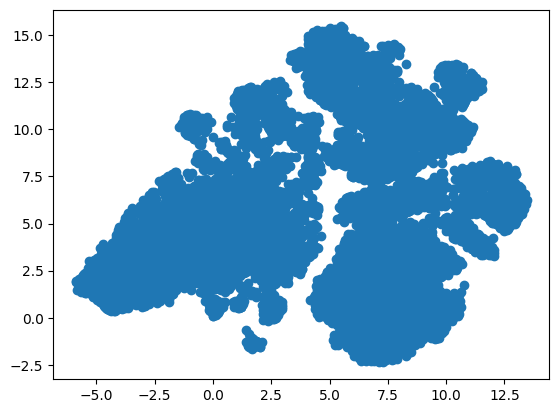

In [180]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=20,
  min_dist=0.77,
  learning_rate=0.05,
  metric="precomputed",
  random_state=17,
  n_jobs=-1
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

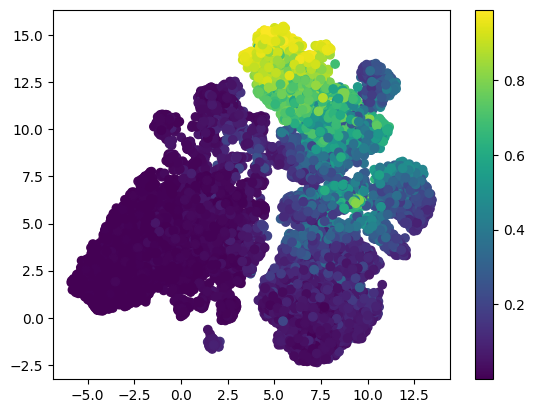

In [181]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(Xtrain_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

Vamos a partir de este embedding para segmentar a los clientes. Puede utilizar cualquier técnica, los datos ya son simples para cualquier algoritmo. Utilizaremos uno bastante estandar

# Clustering

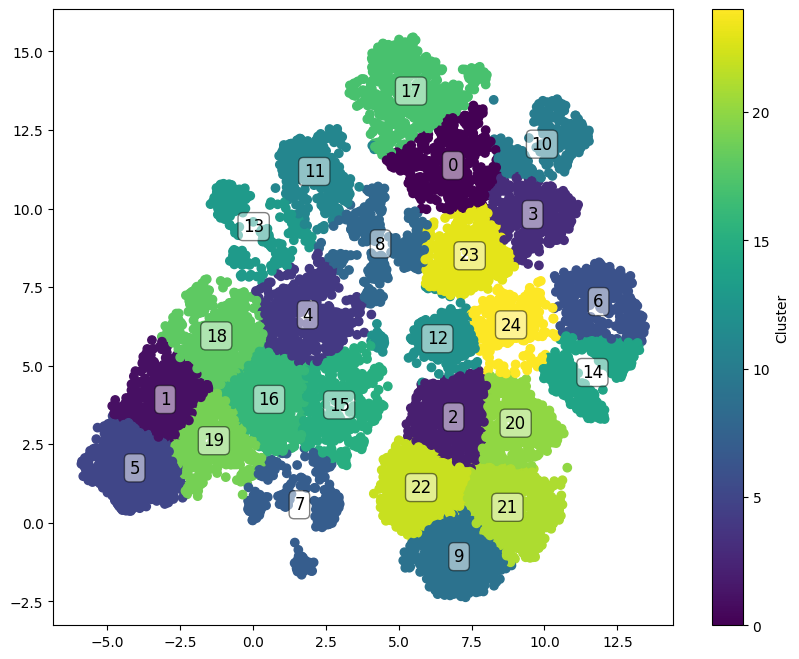

In [255]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=25, random_state=17, n_init=10)
clusters = kmeans.fit_predict(embedding_rf)


plt.figure(figsize=(10, 8))
plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=clusters, cmap='viridis')
plt.colorbar(label='Cluster')

for cluster_label in sorted(np.unique(clusters)):
    cluster_points = embedding_rf[clusters == cluster_label]
    centroid = cluster_points.mean(axis=0)
    plt.text(centroid[0], centroid[1], str(cluster_label), fontsize=12, ha='center', va='center', color='black',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.5))

plt.show()

Veamos cuales de los clientes de cada cluster son **bajas** y cuales **continuan** y la proba promedio del cluster

In [256]:
# agrego a Xtrain_rf_imp la columna cluster
Xtrain_rf_imp["cluster_25"] = clusters

In [257]:
cluster_class_df = pd.DataFrame({'cluster': clusters, 'original_class': ytrain_rf})

class_distribution_by_cluster = cluster_class_df.groupby('cluster')['original_class'].value_counts().unstack(fill_value=0)
cluster_prob_df = pd.DataFrame({'cluster': clusters, 'prob_baja': prob_baja.flatten()})
average_prob_baja_by_cluster = cluster_prob_df.groupby('cluster')['prob_baja'].mean()
class_distribution_by_cluster['average_prob_baja'] = average_prob_baja_by_cluster

print("Number of cases per class and average churn probability per cluster:")
print(class_distribution_by_cluster.sort_values(by='average_prob_baja', ascending=False))
class_distribution_by_cluster.to_csv('class_distribution_by_cluster.csv')

Number of cases per class and average churn probability per cluster:
original_class    0    1  average_prob_baja
cluster                                    
17               46  519               0.89
0               157  346               0.68
3               182  165               0.49
24              157  179               0.46
10              162  105               0.40
23              310  170               0.35
6               202  138               0.33
14              259   57               0.21
12              249   51               0.20
2               422   95               0.18
20              401   61               0.13
8               338   37               0.11
21              579   53               0.08
22              629   31               0.07
11              374   20               0.05
9               821   17               0.04
15              438   13               0.04
13              259    8               0.02
4               526    9               0.02
7      

Por último necesitamos alguna forma de saber que hace a cada cluster distinto del otro. Para esto utilizaremos modelos (**rf**) que buscan separar los cluster uno a uno del resto de los datos.

Por cada modelo, miraremos cuales son las variables más importantes que separan los datos para luego caracterizarlos:

Manos a la obra:

Y exploramos las diferencias entre los clusters usando las **n** variables más importantes, usando en este caso la mediana


# Funciones para analizar clusters

In [187]:
# sacar las features más importantes
importances = model.feature_importances_
feature_names = Xtrain_rf.columns
feature_importance_series = pd.Series(importances, index=feature_names)

feature_selected = feature_importance_series.sort_values(ascending=False)

n_top = 50 # cantidad de variables a evaluar.
top_overall_features = feature_selected.head(n_top).index.tolist()

cluster_series_aligned = pd.Series(clusters, index=Xtrain_rf.index)

# quiero ordenar los clusters por probabilidad de baja promedio

cluster_prob_df = pd.DataFrame({'cluster': clusters, 'prob_baja': prob_baja.flatten()})
average_prob_baja_by_cluster = cluster_prob_df.groupby('cluster')['prob_baja'].mean()
cluster_prob_df = average_prob_baja_by_cluster.reset_index().sort_values(by='prob_baja', ascending=False)
sorted_clusters = cluster_prob_df['cluster'].tolist()   

cluster_median_values = {}

for cluster in sorted_clusters:
    cluster_indices = cluster_series_aligned[cluster_series_aligned == cluster].index
    cluster_data = Xtrain_rf.loc[cluster_indices, top_overall_features]

    # Usar el estadístico de su preferencia
    values = cluster_data.median()
    cluster_median_values[f'Cluster {cluster}'] = values

top_overall_features_df = pd.DataFrame(cluster_median_values)
top_overall_features_df.to_csv('top_overall_features_by_cluster.csv')

In [188]:
cluster_median_values = {}

for cluster in sorted_clusters:
    cluster_indices = cluster_series_aligned[cluster_series_aligned == cluster].index
    cluster_data = Xtrain_rf.loc[cluster_indices, top_overall_features]

    values = cluster_data.median().round(2)
    cluster_median_values[f'Cluster {cluster}'] = values

# clusters como filas, features como columnas
top_overall_features_df = pd.DataFrame(cluster_median_values).T

# Reordenar filas según la lista de clusters ya ordenada por prob_baja
order = [f'Cluster {c}' for c in sorted_clusters]
top_overall_features_df = top_overall_features_df.loc[order]

# Exportar
top_overall_features_df.to_csv("top_overall_features_by_cluster.csv")


In [189]:
cluster_data.head(50)  # o cluster_data


ctrx_quarter  ratio_mcomisiones_mantenimiento_mpasivos_margen  \
474             187                                             0.00   
497             197                                             0.00   
688              76                                             0.00   
728             140                                             0.00   
1152             83                                             0.00   
1344             99                                             0.00   
1535            107                                             0.00   
1918             70                                             0.00   
2030            174                                             0.00   
2135            101                                             0.00   
2505            127                                             0.00   
2924            102                                             0.00   
2934            203                                             0.00   
3390             84                                             0.00   
3678             76                                             0.00   
3877            141                                             0.00   
4013            142                                             0.00   
4251            179                                             0.00   
4301             82                                            -0.00   
4324            183                                             0.00   
4330            225                                             0.00   
4716             84                                             0.00   
4843            138                                             0.00   
4892             50                                             0.00   
5346            121                                             0.00   
5981            127                                             0.00   
6013            227                                            -0.00   
6595            145                                             0.00   
6627             88                                             0.00   
7238            114                                             0.00   
7261             66                                             0.00   
7350            102                                             0.00   
8586            157                                             0.00   
8619            137                                             0.00   
8815             86                                             0.00   
8828            142                                             0.00   
8879            162                                             0.00   
8913            246                                             0.00   
9058            103                                             0.00   
9082            164                                             0.00   
9107            139                                             0.00   
9264            197                                             0.00   
9376            122                                             0.00   
9507            202                                             0.00   
9787            123                                             0.00   
9861            110                                             0.00   
10065           175                                             0.00   
10226           139                                            -0.00   
10316            77                                             0.00   
10437            99                                             0.00   

       mprestamos_personales  slope_ctrx_quarter_window  mcaja_ahorro  \
474                     0.00               -20244224.17      31071.78   
497                 84971.96               -22130550.10       2757.42   
688                     0.00                -7376842.59       1100.54   
728                     0.00              

Otra de forma de explorar es graficar uno contra todos

In [190]:
def compare_cluster_stats(data, clusters, variable_name, target_cluster):

    cluster_series_aligned = pd.Series(clusters, index=data.index)

    variable_data = data[variable_name]

    target_cluster_indices = cluster_series_aligned[cluster_series_aligned == target_cluster].index
    target_cluster_data = variable_data.loc[target_cluster_indices] # Keep NaNs for counting

    rest_indices = cluster_series_aligned[cluster_series_aligned != target_cluster].index
    rest_data = variable_data.loc[rest_indices] # Keep NaNs for counting

    target_cluster_desc = target_cluster_data.dropna().describe()
    rest_desc = rest_data.dropna().describe()

    summary_df = pd.DataFrame({
        f'Cluster {target_cluster}': target_cluster_desc,
        f'Rest of Clusters': rest_desc
    })

    summary_df.loc['unique'] = [target_cluster_data.nunique(), rest_data.nunique()]
    summary_df.loc['missing'] = [target_cluster_data.isnull().sum(), rest_data.isnull().sum()]

    return summary_df

print(f"'mcaja_ahorro' - Cluster 0 vs. Rest")
compare_cluster_stats(Xtrain_rf, clusters, 'ctrx_quarter', 14)

'mcaja_ahorro' - Cluster 0 vs. Rest


Cluster 14  Rest of Clusters
count        316.00          11769.00
mean         125.38            106.60
std          102.01             89.12
min           30.00              0.00
25%           62.75             41.00
50%           96.00             94.00
75%          148.25            149.00
max          883.00           1350.00
unique       171.00            483.00
missing        0.00              0.00

Muy interesante... pero no hay una brújula que nos ayude a ver que variables comparar?

Acá un salvavidas: Crea un modelo que busca separar los clusters del resto de los datos y nos devuelven las variables más importantes de esa separación

In [191]:
important_features_by_cluster = {}
N = 15  # cantidad de features a guardar por cluster

for cluster in sorted(np.unique(clusters)):
    print(f"Training model for Cluster {cluster} vs. Rest...")
    y_binary = (cluster_series_aligned == cluster).astype(int)

    model = RandomForestClassifier(
        n_estimators=100,
        random_state=17,
        class_weight='balanced'
    )
    model.fit(Xtrain_rf_imp, y_binary)

    importances = model.feature_importances_
    feature_names = Xtrain_rf.columns

    indices = np.argsort(importances)[::-1]
    important_features_by_cluster[cluster] = [feature_names[i] for i in indices[:N]]


Training model for Cluster 0 vs. Rest...
Training model for Cluster 1 vs. Rest...
Training model for Cluster 2 vs. Rest...
Training model for Cluster 3 vs. Rest...
Training model for Cluster 4 vs. Rest...
Training model for Cluster 5 vs. Rest...
Training model for Cluster 6 vs. Rest...
Training model for Cluster 7 vs. Rest...
Training model for Cluster 8 vs. Rest...
Training model for Cluster 9 vs. Rest...
Training model for Cluster 10 vs. Rest...
Training model for Cluster 11 vs. Rest...
Training model for Cluster 12 vs. Rest...
Training model for Cluster 13 vs. Rest...
Training model for Cluster 14 vs. Rest...
Training model for Cluster 15 vs. Rest...
Training model for Cluster 16 vs. Rest...
Training model for Cluster 17 vs. Rest...
Training model for Cluster 18 vs. Rest...
Training model for Cluster 19 vs. Rest...
Training model for Cluster 20 vs. Rest...
Training model for Cluster 21 vs. Rest...
Training model for Cluster 22 vs. Rest...
Training model for Cluster 23 vs. Rest...
Tr

Vemos las más importantes para un cluster

In [192]:
print(important_features_by_cluster[14])

['ccomisiones_mantenimiento_delta_1', 'ratio_mpayroll_mcaja_ahorro', 'slope_ccomisiones_mantenimiento_window', 'slope_mcomisiones_mantenimiento_window', 'ratio_mpasivos_margen_mcomisiones_mantenimiento', 'mcomisiones_mantenimiento_delta_1', 'ratio_mpayroll_mcomisiones_otras', 'ratio_mpayroll_mautoservicio', 'ctrx_quarter', 'ratio_mcomisiones_mantenimiento_mpasivos_margen', 'mcomisiones_otras_delta_1', 'mcomisiones_delta_1', 'ccomisiones_mantenimiento', 'mcomisiones_mantenimiento', 'ratio_mpayroll_mcomisiones']


In [193]:
# agrego a 

Y luego miramos los estadísticos

In [194]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpasivos_margen', 0)

Cluster 0  Rest of Clusters
count       503.00          11582.00
mean        -25.29           1454.84
std        1214.84           3915.38
min      -25859.24         -25592.56
25%           0.05            170.26
50%           4.33            571.02
75%          24.26           1414.23
max        2492.15         124444.56
unique      384.00          10931.00
missing       0.00              0.00

Es perfecto? **NO** pero es orientativo

Luego resta, analizar los estadísticos de los datos de cada cluster para las variables importantes, comparar sus distribuciones con histogramas, boxplots, pivot tables, etc.


Junto con el diccionaro de datos, de sentido a lo que ve a través del análisis multivariado de datos.

Obviamente, esto es apenas mas que una semilla. Agregue las variables históricas, juegue con los **rf** y genere una segmentación pro, que encante a Miranda


In [195]:
import pandas as pd
pd.set_option("display.float_format", "{:.2f}".format)


In [196]:
# edad de los clientes del cluster 4 vs resto
compare_cluster_stats(Xtrain_rf, clusters, 'cliente_edad', 4)

Cluster 4  Rest of Clusters
count       535.00          11550.00
mean         44.72             47.02
std          11.92             13.26
min          21.00             20.00
25%          36.00             37.00
50%          43.00             45.00
75%          53.00             56.00
max          84.00             92.00
unique       56.00             72.00
missing       0.00              0.00

In [197]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Supongamos que ya cargaste el dataset en Xtrain_rf
target = "mrentabilidad_annual"
columns_rentabilidad = [col for col in Xtrain_rf.columns if 'rentabilidad' in col]
columns_margen = [col for col in Xtrain_rf.columns if 'margen' in col]
drop_cols = ["numero_de_cliente", "foto_mes", "mrentabilidad"] + columns_rentabilidad  + columns_margen  # no las usamos como features

X = Xtrain_rf.drop(columns=[target] + drop_cols)
y = Xtrain_rf[target]

# Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestRegressor(n_estimators = 207, max_depth = 19, min_samples_split = 32, min_samples_leaf = 29, max_features = None, random_state=17, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Importancia de variables
feat_importance1 = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print(feat_importance1.head(20))


R²: 0.37622161710911395
RMSE: 47690.56493965617
                                          feature  importance
507                     slope_mcaja_ahorro_window        0.38
177                            mcaja_ahorro_lag_1        0.07
443                  master_mlimitecompra_delta_1        0.06
563                slope_mcomisiones_otras_window        0.04
160                          tc_total_msaldopesos        0.04
651             slope_tc_total_mpagominimo_window        0.03
475                      visa_mpagominimo_delta_1        0.02
310                        visa_mpagominimo_lag_1        0.02
170                             mcomisiones_lag_1        0.02
500                      slope_mcomisiones_window        0.01
511                   slope_mcuentas_saldo_window        0.01
289                      master_mpagominimo_lag_1        0.01
233                       mcomisiones_otras_lag_1        0.01
486                  tc_total_mpagominimo_delta_1        0.01
321                   

In [198]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Supongamos que ya cargaste el dataset en Xtrain_rf
target = "mrentabilidad_annual"
columns_rentabilidad = [col for col in Xtrain_rf.columns if 'rentabilidad' in col]
columns_margen = [col for col in Xtrain_rf.columns if 'margen' in col]
columns_lags = [col for col in Xtrain_rf.columns if 'lag' in col]
drop_cols = ["numero_de_cliente", "foto_mes", "mrentabilidad"] + columns_rentabilidad  + columns_margen + columns_lags  # no las usamos como features

X = Xtrain_rf.drop(columns=[target] + drop_cols)
y = Xtrain_rf[target]

# Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestRegressor(n_estimators = 207, max_depth = 19, min_samples_split = 32, min_samples_leaf = 29, max_features = None, random_state=17, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Importancia de variables
feat_importance2 = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print(feat_importance2.head(20))


R²: 0.37844259092019206
RMSE: 47605.58768735941
                                          feature  importance
342                     slope_mcaja_ahorro_window        0.45
278                  master_mlimitecompra_delta_1        0.06
398                slope_mcomisiones_otras_window        0.05
486             slope_tc_total_mpagominimo_window        0.04
160                          tc_total_msaldopesos        0.04
310                      visa_mpagominimo_delta_1        0.02
346                   slope_mcuentas_saldo_window        0.02
335                      slope_mcomisiones_window        0.02
475                 slope_visa_mpagominimo_window        0.01
321                  tc_total_mpagominimo_delta_1        0.01
161                          tc_total_msaldototal        0.01
319                tc_total_mlimitecompra_delta_1        0.01
16                                 mcuentas_saldo        0.01
635  ratio_mcaja_ahorro_mcomisiones_mantenimiento        0.01
454               slop

In [199]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Supongamos que ya cargaste el dataset en Xtrain_rf
target = "mcomisiones"
columns_comision = [col for col in Xtrain_rf.columns if 'comisiones' in col]
columns_rentabilidad = [col for col in Xtrain_rf.columns if 'rentabilidad' in col]
columns_margen = [col for col in Xtrain_rf.columns if 'margen' in col]
columns_lags = [col for col in Xtrain_rf.columns if 'lag' in col]
drop_cols = ["numero_de_cliente", "foto_mes", "mrentabilidad"] + columns_rentabilidad  + columns_margen + columns_lags  + columns_comision # no las usamos como features

X = Xtrain_rf.drop(columns=[target] + drop_cols)
y = Xtrain_rf[target]

# Entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestRegressor(n_estimators = 207, max_depth = 19, min_samples_split = 32, min_samples_leaf = 29, max_features = None, random_state=17, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluación
y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Importancia de variables
feat_importance3 = pd.DataFrame({
    "feature": X.columns,
    "importance": model.feature_importances_
}).sort_values("importance", ascending=False)

print(feat_importance3.head(20))


R²: 0.3041527918456247
RMSE: 1507.1482237420153
                                               feature  importance
21                               mtarjeta_visa_consumo        0.08
365                              slope_mpayroll_window        0.07
153                               tc_total_mpagospesos        0.06
467                slope_tc_total_mconsumototal_window        0.05
341                 slope_mtarjeta_visa_consumo_window        0.04
390             slope_mtransferencias_recibidas_window        0.04
155                               tc_total_msaldopesos        0.03
971  ratio_mttarjeta_visa_debitos_automaticos_mpayroll        0.03
364                          slope_cpayroll_trx_window        0.02
156                               tc_total_msaldototal        0.02
466               slope_tc_total_mconsumospesos_window        0.02
473                  slope_tc_total_mpagospesos_window        0.02
70                           mtransferencias_recibidas        0.02
146           

In [200]:
columns_rentabilidad

['mrentabilidad',
 'mrentabilidad_annual',
 'mrentabilidad_lag_1',
 'mrentabilidad_annual_lag_1',
 'mrentabilidad_delta_1',
 'mrentabilidad_annual_delta_1',
 'slope_mrentabilidad_window',
 'slope_mrentabilidad_annual_window',
 'ratio_mactivos_margen_mrentabilidad',
 'ratio_mrentabilidad_mactivos_margen',
 'ratio_mactivos_margen_mrentabilidad_annual',
 'ratio_mrentabilidad_annual_mactivos_margen',
 'ratio_matm_mrentabilidad',
 'ratio_mrentabilidad_matm',
 'ratio_matm_mrentabilidad_annual',
 'ratio_mrentabilidad_annual_matm',
 'ratio_matm_other_mrentabilidad',
 'ratio_matm_other_mrentabilidad_annual',
 'ratio_mautoservicio_mrentabilidad',
 'ratio_mrentabilidad_mautoservicio',
 'ratio_mautoservicio_mrentabilidad_annual',
 'ratio_mrentabilidad_annual_mautoservicio',
 'ratio_mcaja_ahorro_mrentabilidad',
 'ratio_mrentabilidad_mcaja_ahorro',
 'ratio_mcaja_ahorro_mrentabilidad_annual',
 'ratio_mrentabilidad_annual_mcaja_ahorro',
 'ratio_mcaja_ahorro_adicional_mrentabilidad',
 'ratio_mcaja_ahor

# Look-alike modeling

In [201]:
features_valor = (
    feat_importance1['feature'].iloc[:20].tolist() +
    feat_importance2['feature'].iloc[:20].tolist() +
    feat_importance3['feature'].iloc[:20].tolist()
)

# Sacar duplicados preservando el orden
features_valor = list(dict.fromkeys(features_valor))

features_valor



['slope_mcaja_ahorro_window',
 'mcaja_ahorro_lag_1',
 'master_mlimitecompra_delta_1',
 'slope_mcomisiones_otras_window',
 'tc_total_msaldopesos',
 'slope_tc_total_mpagominimo_window',
 'visa_mpagominimo_delta_1',
 'visa_mpagominimo_lag_1',
 'mcomisiones_lag_1',
 'slope_mcomisiones_window',
 'slope_mcuentas_saldo_window',
 'master_mpagominimo_lag_1',
 'mcomisiones_otras_lag_1',
 'tc_total_mpagominimo_delta_1',
 'tc_total_mpagominimo_lag_1',
 'tc_total_mlimitecompra_delta_1',
 'ratio_mcaja_ahorro_mcomisiones_mantenimiento',
 'slope_visa_mpagominimo_window',
 'tc_total_msaldototal',
 'mcuentas_saldo_lag_1',
 'mcuentas_saldo',
 'slope_master_mpagominimo_window',
 'mcaja_ahorro',
 'tc_total_mpagominimo',
 'mplazo_fijo_dolares',
 'mcomisiones_delta_1',
 'slope_internet_window',
 'mtarjeta_visa_consumo',
 'slope_mpayroll_window',
 'tc_total_mpagospesos',
 'slope_tc_total_mconsumototal_window',
 'slope_mtarjeta_visa_consumo_window',
 'slope_mtransferencias_recibidas_window',
 'ratio_mttarjeta_

In [202]:
features_comparacion = [
    "ctrx_quarter",
    "ratio_mcomisiones_mantenimiento_mpasivos_margen",
    "mprestamos_personales",
    "slope_ctrx_quarter_window",
    "mcaja_ahorro",
    "slope_mcaja_ahorro_window",
    "cpayroll_trx",
    "mtarjeta_visa_consumo",
    "mpayroll",
    "mpasivos_margen"
]


In [203]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Escalar las variables de comparación
X = Xtrain_rf[features_comparacion].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# Clusterización
kmeans = KMeans(n_clusters=5, random_state=42)
Xtrain_rf["cluster"] = kmeans.fit_predict(X_scaled)


In [204]:
# Promedio de los features de valor por cluster
cluster_profiles = Xtrain_rf.groupby("cluster")[features_valor].mean()

# También podés ver la proporción de clientes con valores > 0
cluster_presence = Xtrain_rf[features_valor + ["cluster"]].gt(0).groupby("cluster").mean()


In [205]:
import numpy as np

similaridades = {}

for f in features_valor:
    clientes_con_f = Xtrain_rf[Xtrain_rf[f] > 0][features_comparacion].mean()
    cluster_means = Xtrain_rf.groupby("cluster")[features_comparacion].mean()
    
    # Distancia euclídea entre cada cluster y el grupo "clientes con f"
    distancias = cluster_means.apply(lambda row: np.linalg.norm(row - clientes_con_f), axis=1)
    similaridades[f] = distancias.idxmin()  # cluster más parecido


C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\329854888.py:11: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  similaridades[f] = distancias.idxmin()  # cluster más parecido
C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\329854888.py:11: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  similaridades[f] = distancias.idxmin()  # cluster más parecido
C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\329854888.py:11: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  similaridades[f] = distancias.idxmin()  # cluster más parecido
C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\329854888.py:11: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and s

In [206]:
import numpy as np
import pandas as pd
df = Xtrain_rf.copy()
resultados = []

for f in features_valor:
    clientes_con_f = df[df[f] > 0][features_comparacion].mean()
    # Si todos los valores son NaN, saltar este feature
    if clientes_con_f.isnull().all():
        continue

    cluster_means = df.groupby("cluster")[features_comparacion].mean()
    distancias = cluster_means.apply(lambda row: np.linalg.norm(row - clientes_con_f), axis=1)

    # Si todas las distancias son NaN, saltar este feature
    if distancias.isnull().all():
        continue

    # Normalizar distancias
    dist_norm = distancias / distancias.max()

    # Si todas las distancias normalizadas son NaN, saltar este feature
    if dist_norm.isnull().all():
        continue

    # Cluster más cercano (evitar nan)
    best_cluster = dist_norm.idxmin()
    if pd.isna(best_cluster):
        continue

    # % de clientes en ese cluster que ya tienen el feature
    pct_con_f = (df.loc[df["cluster"] == best_cluster, f] > 0).mean()

    resultados.append({
        "Cluster": best_cluster,
        "Feature recomendado": f,
        "Distancia normalizada": dist_norm[best_cluster],
        "% clientes que ya lo tienen": round(100*pct_con_f, 1)
    })

tabla_recomendaciones = pd.DataFrame(resultados)


# Clusters 0 y 17

In [173]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count         mean  \
numero_de_cliente                                  1350.00 698723434.25   
foto_mes                                           1350.00    202104.00   
active_quarter                                     1350.00         1.00   
cliente_vip                                        1350.00         0.01   
internet                                           1350.00         0.01   
...                                                    ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra... 1019.00         0.06   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  943.00        73.10   
ratio_mttarjeta_visa_debitos_automaticos_mtrans... 1019.00         0.40   
ratio_mttarjeta_master_debitos_automaticos_mtta...  943.00         0.38   
ratio_mttarjeta_visa_debitos_automaticos_mttarj...  211.00        13.34   

                                                            std          min  \
numero_de_cliente                                  305533465.73 249803647.00   
foto_mes                                                   0.00    202104.00   
active_quarter                                             0.00         1.00   
cliente_vip                                                0.09         0.00   
internet                                                   0.09         0.00   
...                                                         ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...         0.80         0.00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...       396.41         0.00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         1.73         0.00   
ratio_mttarjeta_master_debitos_automaticos_mtta...         2.34         0.00   
ratio_mttarjeta_visa_debitos_automaticos_mttarj...        49.59         0.00   

                                                            25%          50%  \
numero_de_cliente                                  474959506.75 649210155.00   
foto_mes                                              202104.00    202104.00   
active_quarter                                             1.00         1.00   
cliente_vip                                                0.00         0.00   
internet                                                   0.00         0.00   
...                                                         ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...         0.00         0.00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...         0.49         5.49   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         0.00         0.04   
ratio_mttarjeta_master_debitos_automaticos_mtta...         0.00         0.00   
ratio_mttarjeta_visa_debitos_automaticos_mttarj...         0.25         1.94   

                                                            75%           max  
numero_de_cliente                                  898318173.75 1556496050.00  
foto_mes                                              202104.00     202104.00  
active_quarter                                             1.00          1.00  
cliente_vip                                                0.00          1.00  
internet                                                   0.00          2.00  
...                                                         ...           ...  
ratio_mttarjeta_master_debitos_automaticos_mtra...         0.00         23.19  
ratio_mtransferencias_recibidas_mttarjeta_visa_...        25.52       7624.18  
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         0.19         26.99  
ratio_mttarjeta_master_debitos_automaticos_mtta...         0.00         38.38  
ratio_mttarjeta_visa_debitos_automaticos_mttarj...         6.88        559.49  

[2672 rows x 8 columns]

In [65]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [66]:
Xtrain_rf_imp_cluster0_17 = Xtrain_rf_imp[
    (Xtrain_rf_imp["cluster_25"] == 0) | (Xtrain_rf_imp["cluster_25"] == 17)
]

Xtrain_rf_imp_cluster0_17.describe().T



count         mean  \
numero_de_cliente                                  1068.00 864857224.51   
foto_mes                                           1068.00    202104.00   
active_quarter                                     1068.00         0.65   
cliente_vip                                        1068.00         0.00   
internet                                           1068.00         0.25   
...                                                    ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_... 1068.00         5.47   
ratio_mttarjeta_visa_debitos_automaticos_mtrans... 1068.00         0.44   
ratio_mttarjeta_master_debitos_automaticos_mtta... 1068.00         0.00   
cluster_25                                         1068.00         8.99   
mcaja_ahorro_dolares_dummy                         1068.00         0.22   

                                                            std          min  \
numero_de_cliente                                  340986115.93 249709864.00   
foto_mes                                                   0.00    202104.00   
active_quarter                                             0.48         0.00   
cliente_vip                                                0.04         0.00   
internet                                                   0.53         0.00   
...                                                         ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...        19.71         0.00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...        10.58         0.00   
ratio_mttarjeta_master_debitos_automaticos_mtta...         0.04         0.00   
cluster_25                                                 8.49         0.00   
mcaja_ahorro_dolares_dummy                                 0.42         0.00   

                                                            25%          50%  \
numero_de_cliente                                  600740474.75 847385550.50   
foto_mes                                              202104.00    202104.00   
active_quarter                                             0.00         1.00   
cliente_vip                                                0.00         0.00   
internet                                                   0.00         0.00   
...                                                         ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...         4.85         4.85   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         0.03         0.03   
ratio_mttarjeta_master_debitos_automaticos_mtta...         0.00         0.00   
cluster_25                                                 0.00        17.00   
mcaja_ahorro_dolares_dummy                                 0.00         0.00   

                                                             75%           max  
numero_de_cliente                                  1132432226.75 1589740654.00  
foto_mes                                               202104.00     202104.00  
active_quarter                                              1.00          1.00  
cliente_vip                                                 0.00          1.00  
internet                                                    0.00          3.00  
...                                                          ...           ...  
ratio_mtransferencias_recibidas_mttarjeta_visa_...          4.85        558.73  
ratio_mttarjeta_visa_debitos_automaticos_mtrans...          0.03        328.19  
ratio_mttarjeta_master_debitos_automaticos_mtta...          0.00          1.31  
cluster_25                                                 17.00         17.00  
mcaja_ahorro_dolares_dummy                                  0.00          1.00  

[1650 rows x 8 columns]

In [67]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.00    1066
1.00       2
Name: count, dtype: int64

In [68]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.00    849
1.00    174
2.00     42
3.00      3
Name: count, dtype: int64

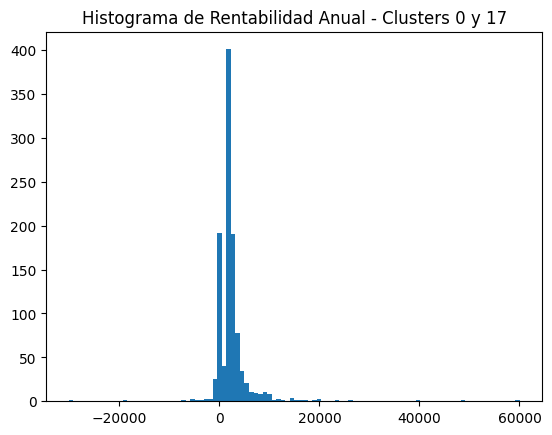

In [69]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


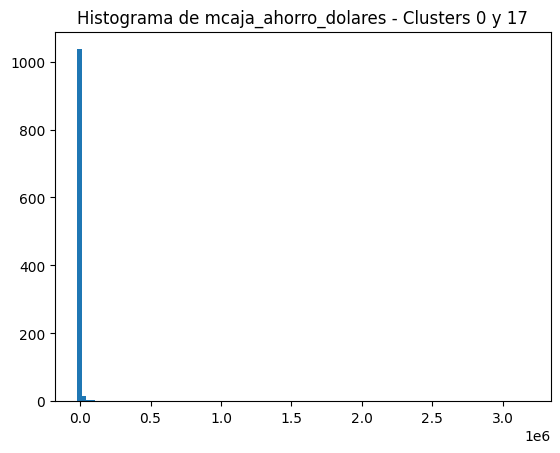

In [70]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [71]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [72]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")
# share of 1 for each cluster
tabla_fmt["share_of_1"] = (100 * tabla[1] / (tabla[0] + tabla[1])).round(1).astype(str) + "%"

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\2909352463.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1 share_of_1
cluster_25                                     
0                           370  133      26.4%
1                           253  310      55.1%
2                           291  226      43.7%
3                           279   68      19.6%
4                           297  238      44.5%
5                           348  589      62.9%
6                           189  151      44.4%
7                            85  234      73.4%
8                           245  130      34.7%
9                           187  651      77.7%
10                          214   53      19.9%
11                          216  178      45.2%
12                          183  117      39.0%
13                           84  183      68.5%
14                          133  183      57.9%
15                          154  297      65.9%
16                          212  375      63.9%
17                          460  105      18.6%
18                          178  360      66.9%
19                          154  402      72.3%
20                          277  185      40.0%
21                          212  420      66.5%
22                          220  440      66.7%
23                          263  217      45.2%
24                          202  134      39.9%

In [73]:
# share total de clientes con caja ahorro dolares > 0
total_clients = len(Xtrain_rf_imp)
clients_with_caja_ahorro_dolares = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).sum()
share_total = 100 * clients_with_caja_ahorro_dolares / total_clients

print(share_total)

52.78444352503103


# Cluster 3


# Cluster 24


In [75]:
# analizo cluster 24, que lo diferencia de los demas

# separador de miles para todo

for i in important_features_by_cluster[24]:
    print(f"' {i} ' - Cluster 24 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf, clusters, i, 24).round(0).style.format("{:,.0f}"))

KeyError: 24

In [77]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count         mean  \
numero_de_cliente                                  1350.00 698723434.25   
foto_mes                                           1350.00    202104.00   
active_quarter                                     1350.00         1.00   
cliente_vip                                        1350.00         0.01   
internet                                           1350.00         0.01   
...                                                    ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra... 1019.00         0.06   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  943.00        73.10   
ratio_mttarjeta_visa_debitos_automaticos_mtrans... 1019.00         0.40   
ratio_mttarjeta_master_debitos_automaticos_mtta...  943.00         0.38   
cluster                                            1350.00         0.70   

                                                            std          min  \
numero_de_cliente                                  305533465.73 249803647.00   
foto_mes                                                   0.00    202104.00   
active_quarter                                             0.00         1.00   
cliente_vip                                                0.09         0.00   
internet                                                   0.09         0.00   
...                                                         ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...         0.80         0.00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...       396.41         0.00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         1.73         0.00   
ratio_mttarjeta_master_debitos_automaticos_mtta...         2.34         0.00   
cluster                                                    0.85         0.00   

                                                            25%          50%  \
numero_de_cliente                                  474959506.75 649210155.00   
foto_mes                                              202104.00    202104.00   
active_quarter                                             1.00         1.00   
cliente_vip                                                0.00         0.00   
internet                                                   0.00         0.00   
...                                                         ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...         0.00         0.00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...         0.49         5.49   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         0.00         0.04   
ratio_mttarjeta_master_debitos_automaticos_mtta...         0.00         0.00   
cluster                                                    0.00         1.00   

                                                            75%           max  
numero_de_cliente                                  898318173.75 1556496050.00  
foto_mes                                              202104.00     202104.00  
active_quarter                                             1.00          1.00  
cliente_vip                                                0.00          1.00  
internet                                                   0.00          2.00  
...                                                         ...           ...  
ratio_mttarjeta_master_debitos_automaticos_mtra...         0.00         23.19  
ratio_mtransferencias_recibidas_mttarjeta_visa_...        25.52       7624.18  
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         0.19         26.99  
ratio_mttarjeta_master_debitos_automaticos_mtta...         0.00         38.38  
cluster                                                    1.00          4.00  

[1649 rows x 8 columns]

In [78]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [79]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 24)]

Xtrain_rf_imp_cluster3.describe().T



count         mean  \
numero_de_cliente                                  336.00 805663776.81   
foto_mes                                           336.00    202104.00   
active_quarter                                     336.00         1.00   
cliente_vip                                        336.00         0.00   
internet                                           336.00         0.10   
...                                                   ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_... 336.00        17.31   
ratio_mttarjeta_visa_debitos_automaticos_mtrans... 336.00         0.31   
ratio_mttarjeta_master_debitos_automaticos_mtta... 336.00         0.09   
cluster_25                                         336.00        24.00   
mcaja_ahorro_dolares_dummy                         336.00         0.40   

                                                            std          min  \
numero_de_cliente                                  310156128.73 251008988.00   
foto_mes                                                   0.00    202104.00   
active_quarter                                             0.00         1.00   
cliente_vip                                                0.00         0.00   
internet                                                   0.38         0.00   
...                                                         ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...        94.31         0.00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         2.99         0.00   
ratio_mttarjeta_master_debitos_automaticos_mtta...         0.70         0.00   
cluster_25                                                 0.00        24.00   
mcaja_ahorro_dolares_dummy                                 0.49         0.00   

                                                            25%          50%  \
numero_de_cliente                                  582984943.75 780135382.50   
foto_mes                                              202104.00    202104.00   
active_quarter                                             1.00         1.00   
cliente_vip                                                0.00         0.00   
internet                                                   0.00         0.00   
...                                                         ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...         4.61         4.85   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         0.00         0.03   
ratio_mttarjeta_master_debitos_automaticos_mtta...         0.00         0.00   
cluster_25                                                24.00        24.00   
mcaja_ahorro_dolares_dummy                                 0.00         0.00   

                                                             75%           max  
numero_de_cliente                                  1049784007.00 1536984192.00  
foto_mes                                               202104.00     202104.00  
active_quarter                                              1.00          1.00  
cliente_vip                                                 0.00          0.00  
internet                                                    0.00          3.00  
...                                                          ...           ...  
ratio_mtransferencias_recibidas_mttarjeta_visa_...          4.85       1376.76  
ratio_mttarjeta_visa_debitos_automaticos_mtrans...          0.03         51.24  
ratio_mttarjeta_master_debitos_automaticos_mtta...          0.00         10.32  
cluster_25                                                 24.00         24.00  
mcaja_ahorro_dolares_dummy                                  1.00          1.00  

[1650 rows x 8 columns]

In [80]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.00    1066
1.00       2
Name: count, dtype: int64

In [81]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.00    849
1.00    174
2.00     42
3.00      3
Name: count, dtype: int64

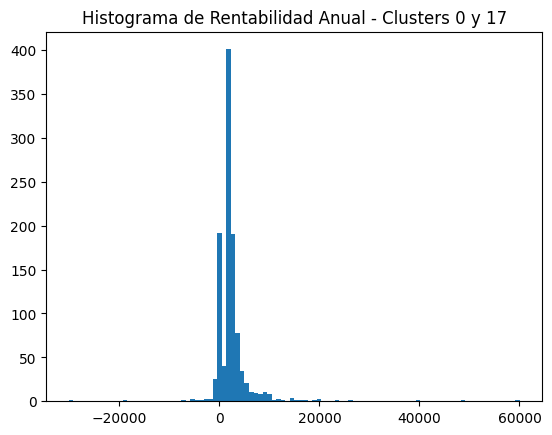

In [82]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


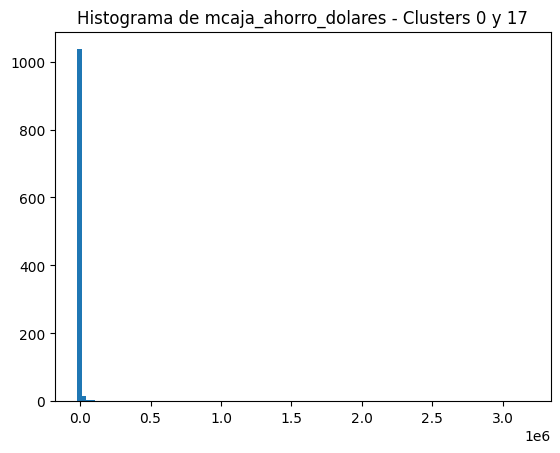

In [83]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [84]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [85]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [86]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count         mean  \
numero_de_cliente                                  1350.00 698723434.25   
foto_mes                                           1350.00    202104.00   
active_quarter                                     1350.00         1.00   
cliente_vip                                        1350.00         0.01   
internet                                           1350.00         0.01   
...                                                    ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra... 1019.00         0.06   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  943.00        73.10   
ratio_mttarjeta_visa_debitos_automaticos_mtrans... 1019.00         0.40   
ratio_mttarjeta_master_debitos_automaticos_mtta...  943.00         0.38   
cluster                                            1350.00         0.70   

                                                            std          min  \
numero_de_cliente                                  305533465.73 249803647.00   
foto_mes                                                   0.00    202104.00   
active_quarter                                             0.00         1.00   
cliente_vip                                                0.09         0.00   
internet                                                   0.09         0.00   
...                                                         ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...         0.80         0.00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...       396.41         0.00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         1.73         0.00   
ratio_mttarjeta_master_debitos_automaticos_mtta...         2.34         0.00   
cluster                                                    0.85         0.00   

                                                            25%          50%  \
numero_de_cliente                                  474959506.75 649210155.00   
foto_mes                                              202104.00    202104.00   
active_quarter                                             1.00         1.00   
cliente_vip                                                0.00         0.00   
internet                                                   0.00         0.00   
...                                                         ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...         0.00         0.00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...         0.49         5.49   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         0.00         0.04   
ratio_mttarjeta_master_debitos_automaticos_mtta...         0.00         0.00   
cluster                                                    0.00         1.00   

                                                            75%           max  
numero_de_cliente                                  898318173.75 1556496050.00  
foto_mes                                              202104.00     202104.00  
active_quarter                                             1.00          1.00  
cliente_vip                                                0.00          1.00  
internet                                                   0.00          2.00  
...                                                         ...           ...  
ratio_mttarjeta_master_debitos_automaticos_mtra...         0.00         23.19  
ratio_mtransferencias_recibidas_mttarjeta_visa_...        25.52       7624.18  
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         0.19         26.99  
ratio_mttarjeta_master_debitos_automaticos_mtta...         0.00         38.38  
cluster                                                    1.00          4.00  

[1649 rows x 8 columns]

In [87]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

# Cluster 3

In [88]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 3)]

Xtrain_rf_imp_cluster3.describe().T



count         mean  \
numero_de_cliente                                  347.00 840176004.73   
foto_mes                                           347.00    202104.00   
active_quarter                                     347.00         0.96   
cliente_vip                                        347.00         0.00   
internet                                           347.00         0.08   
...                                                   ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_... 347.00         3.76   
ratio_mttarjeta_visa_debitos_automaticos_mtrans... 347.00         0.13   
ratio_mttarjeta_master_debitos_automaticos_mtta... 347.00         0.19   
cluster_25                                         347.00         3.00   
mcaja_ahorro_dolares_dummy                         347.00         0.20   

                                                            std          min  \
numero_de_cliente                                  322986074.86 252453962.00   
foto_mes                                                   0.00    202104.00   
active_quarter                                             0.20         0.00   
cliente_vip                                                0.00         0.00   
internet                                                   0.32         0.00   
...                                                         ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...         7.04         0.00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         0.48         0.00   
ratio_mttarjeta_master_debitos_automaticos_mtta...         2.12         0.00   
cluster_25                                                 0.00         3.00   
mcaja_ahorro_dolares_dummy                                 0.40         0.00   

                                                            25%          50%  \
numero_de_cliente                                  598722602.00 845283030.00   
foto_mes                                              202104.00    202104.00   
active_quarter                                             1.00         1.00   
cliente_vip                                                0.00         0.00   
internet                                                   0.00         0.00   
...                                                         ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...         0.00         4.85   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...         0.03         0.03   
ratio_mttarjeta_master_debitos_automaticos_mtta...         0.00         0.00   
cluster_25                                                 3.00         3.00   
mcaja_ahorro_dolares_dummy                                 0.00         0.00   

                                                             75%           max  
numero_de_cliente                                  1082510061.50 1557339451.00  
foto_mes                                               202104.00     202104.00  
active_quarter                                              1.00          1.00  
cliente_vip                                                 0.00          0.00  
internet                                                    0.00          2.00  
...                                                          ...           ...  
ratio_mtransferencias_recibidas_mttarjeta_visa_...          4.85         73.24  
ratio_mttarjeta_visa_debitos_automaticos_mtrans...          0.03          5.74  
ratio_mttarjeta_master_debitos_automaticos_mtta...          0.00         32.74  
cluster_25                                                  3.00          3.00  
mcaja_ahorro_dolares_dummy                                  0.00          1.00  

[1650 rows x 8 columns]

In [89]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.00    1066
1.00       2
Name: count, dtype: int64

In [90]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.00    849
1.00    174
2.00     42
3.00      3
Name: count, dtype: int64

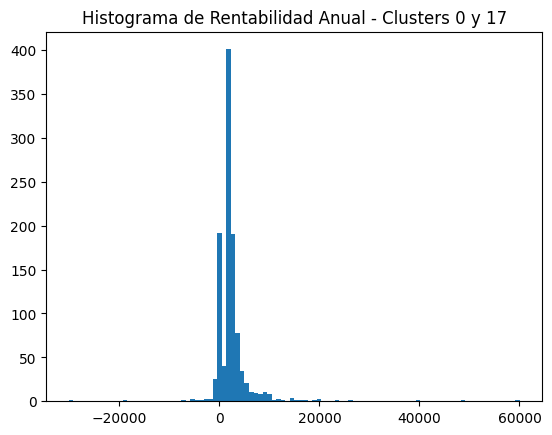

In [91]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


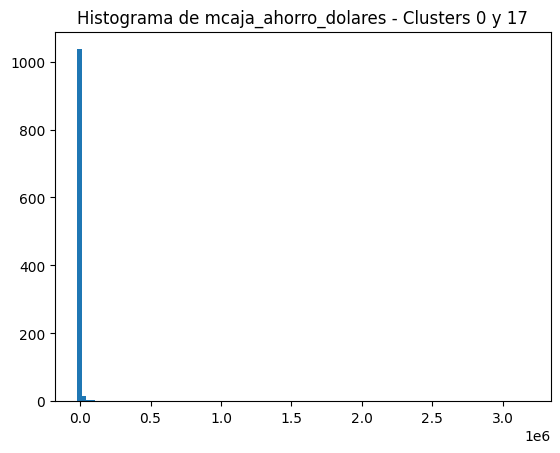

In [92]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [93]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [94]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [95]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll', 24)

Cluster 24  Rest of Clusters
count        336.00          11749.00
mean        1609.20          67096.50
std        11420.57         219910.46
min            0.00              0.00
25%            0.00              0.00
50%            0.00              0.00
75%            0.00          99454.86
max       124338.00       16056812.25
unique        11.00           5349.00
missing        0.00              0.00

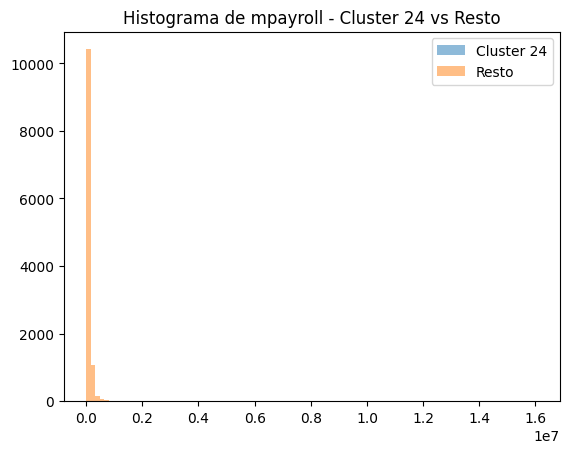

In [96]:
# histograma comparando mpayroll de cluster 24 vs resto
plt.hist(Xtrain_rf_imp_cluster3["mpayroll"], bins=100, alpha=0.5, label='Cluster 24')
plt.hist(Xtrain_rf_imp[ Xtrain_rf_imp["cluster_25"] != 24]["mpayroll"], bins=100, alpha=0.5, label='Resto')
plt.title("Histograma de mpayroll - Cluster 24 vs Resto")
plt.legend()
plt.show()

In [97]:
# analizo cluster 24, que lo diferencia de los demas

# separador de miles para todo


for i in important_features_by_cluster[24]:
    print(f"' {i} ' - Cluster 24 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf, clusters, i, 24).round(0).style.format("{:,.0f}"))

KeyError: 24

In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 24)]

Xtrain_rf_imp_cluster3.describe().T



count          mean  \
numero_de_cliente                                   336.0  8.056638e+08   
foto_mes                                            336.0  2.021040e+05   
active_quarter                                      336.0  1.000000e+00   
cliente_vip                                         336.0  0.000000e+00   
internet                                            336.0  1.011905e-01   
...                                                   ...           ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  336.0  1.731026e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  336.0  3.075606e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...  336.0  8.773891e-02   
cluster_25                                          336.0  2.400000e+01   
mcaja_ahorro_dolares_dummy                          336.0  3.988095e-01   

                                                             std          min  \
numero_de_cliente                                   3.101561e+08  251008988.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         0.000000e+00          0.0   
internet                                            3.807280e-01          0.0   
...                                                          ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  9.430814e+01          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.987613e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  7.040902e-01          0.0   
cluster_25                                          0.000000e+00         24.0   
mcaja_ahorro_dolares_dummy                          4.903837e-01          0.0   

                                                             25%  \
numero_de_cliente                                   5.829849e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.614856e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             50%  \
numero_de_cliente                                   7.801354e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.764425e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             75%           max  
numero_de_cliente                                   1.049784e+09  1.536984e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  0.000000e+00  
internet                                            0.000000e+00  3.000000e+00  
...                                                       

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

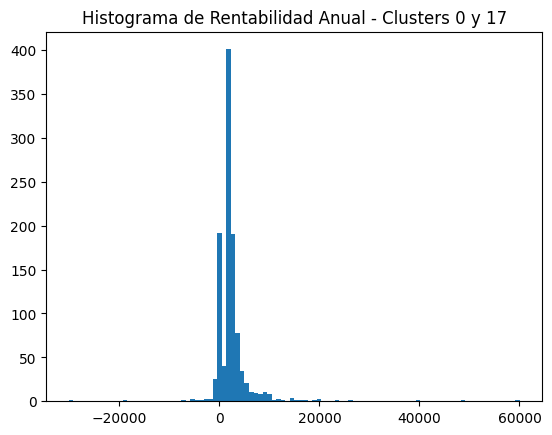

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


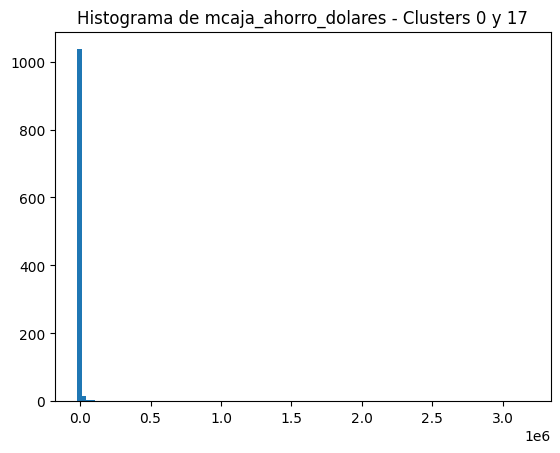

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 3)]

Xtrain_rf_imp_cluster3.describe().T



numero_de_cliente  foto_mes  active_quarter  cliente_vip    internet  \
count       3.470000e+02     347.0      347.000000        347.0  347.000000   
mean        8.401760e+08  202104.0        0.956772          0.0    0.080692   
std         3.229861e+08       0.0        0.203663          0.0    0.321398   
min         2.524540e+08  202104.0        0.000000          0.0    0.000000   
25%         5.987226e+08  202104.0        1.000000          0.0    0.000000   
50%         8.452830e+08  202104.0        1.000000          0.0    0.000000   
75%         1.082510e+09  202104.0        1.000000          0.0    0.000000   
max         1.557339e+09  202104.0        1.000000          0.0    2.000000   

       cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
count    347.000000          347.000000     347.000000            347.000000   
mean      49.020173           96.962536     778.537205           5981.057118   
std       12.864664           76.171174    2472.159911          20228.095725   
min       21.000000            2.000000  -10721.820000         -88663.590000   
25%       39.000000           41.000000     -78.080000          -1639.200000   
50%       48.000000           72.000000     941.440000           3162.260000   
75%       59.000000          139.500000    1980.180000          12578.480000   
max       82.000000          376.000000   20009.040000         197526.470000   

       mcomisiones  ...  \
count   347.000000  ...   
mean   1211.081643  ...   
std    1205.092474  ...   
min   -4713.950000  ...   
25%     160.865000  ...   
50%    1592.200000  ...   
75%    2042.940000  ...   
max    5967.410000  ...   

       ratio_mtransferencias_recibidas_mtransferencias_emitidas  \
count                                         347.000000          
mean                                           51.595299          
std                                           933.554321          
min                                             0.000000          
25%                                             1.495924          
50%                                             1.495924          
75%                                             1.495924          
max                                         17391.666667          

       ratio_mttarjeta_master_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                     
mean                                            0.049999                     
std                                             0.830112                     
min                                             0.000000                     
25%                                             0.000000                     
50%                                             0.000000                     
75%                                             0.000000                     
max                                            15.387458                     

       ratio_mtransferencias_emitidas_mttarjeta_visa_debitos_automaticos  \
count                                         347.000000                   
mean                                            0.615258                   
std                                             0.664527                   
min                                             0.000000                   
25%                                             0.000000                   
50%                                             0.028475                   
75%                                             1.212098                   
max                                             5.717091                   

       ratio_mttarjeta_visa_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                   
mean                                            0.164953                   
std                                             1.885002                   
min                               

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

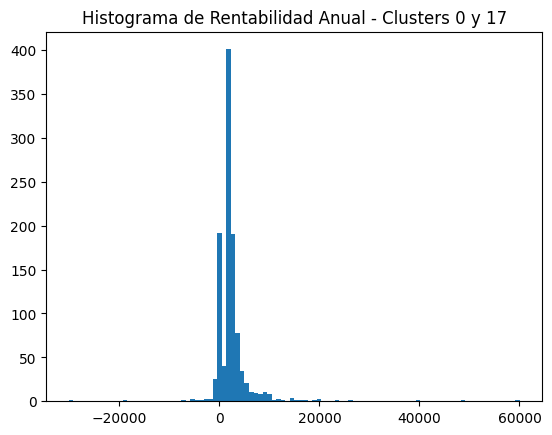

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


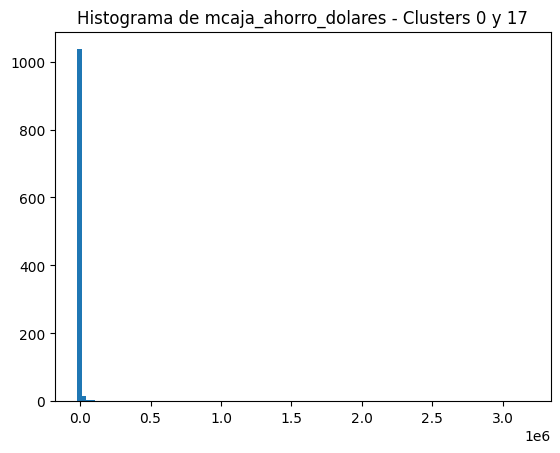

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll', 24)

Cluster 24  Rest of Clusters
count       336.000000      1.174900e+04
mean       1609.198810      6.709650e+04
std       11420.571989      2.199105e+05
min           0.000000      0.000000e+00
25%           0.000000      0.000000e+00
50%           0.000000      0.000000e+00
75%           0.000000      9.945486e+04
max      124338.000000      1.605681e+07
unique       11.000000      5.349000e+03
missing       0.000000      0.000000e+00

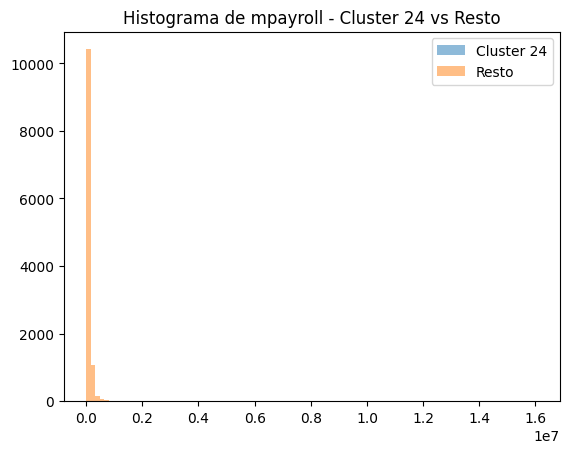

In [ ]:
# histograma comparando mpayroll de cluster 24 vs resto
plt.hist(Xtrain_rf_imp_cluster3["mpayroll"], bins=100, alpha=0.5, label='Cluster 24')
plt.hist(Xtrain_rf_imp[ Xtrain_rf_imp["cluster_25"] != 24]["mpayroll"], bins=100, alpha=0.5, label='Resto')
plt.title("Histograma de mpayroll - Cluster 24 vs Resto")
plt.legend()
plt.show()

In [101]:
# analizo cluster 24, que lo diferencia de los demas

# separador de miles para todo


for i in important_features_by_cluster[0]:
    print(f"' {i} ' - Cluster 0 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf, clusters, i, 0).round(0).style.format("{:,.0f}"))

' cluster ' - Cluster 0 vs. Rest


' slope_ctrx_quarter_window ' - Cluster 0 vs. Rest


' ctrx_quarter ' - Cluster 0 vs. Rest


' mtarjeta_visa_consumo ' - Cluster 0 vs. Rest


' mpasivos_margen ' - Cluster 0 vs. Rest


' mcaja_ahorro ' - Cluster 0 vs. Rest


' slope_mcaja_ahorro_window ' - Cluster 0 vs. Rest


' slope_mpasivos_margen_window ' - Cluster 0 vs. Rest


' slope_TC_Total_mconsumototal_window ' - Cluster 0 vs. Rest


' ctrx_quarter_lag_1 ' - Cluster 0 vs. Rest


' TC_Total_mpagospesos ' - Cluster 0 vs. Rest


' mcaja_ahorro_lag_1 ' - Cluster 0 vs. Rest


' slope_ctarjeta_visa_transacciones_window ' - Cluster 0 vs. Rest


' TC_Total_msaldototal_lag_1 ' - Cluster 0 vs. Rest


' mautoservicio ' - Cluster 0 vs. Rest


In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 24)]

Xtrain_rf_imp_cluster3.describe().T



count          mean  \
numero_de_cliente                                   336.0  8.056638e+08   
foto_mes                                            336.0  2.021040e+05   
active_quarter                                      336.0  1.000000e+00   
cliente_vip                                         336.0  0.000000e+00   
internet                                            336.0  1.011905e-01   
...                                                   ...           ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  336.0  1.731026e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  336.0  3.075606e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...  336.0  8.773891e-02   
cluster_25                                          336.0  2.400000e+01   
mcaja_ahorro_dolares_dummy                          336.0  3.988095e-01   

                                                             std          min  \
numero_de_cliente                                   3.101561e+08  251008988.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         0.000000e+00          0.0   
internet                                            3.807280e-01          0.0   
...                                                          ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  9.430814e+01          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.987613e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  7.040902e-01          0.0   
cluster_25                                          0.000000e+00         24.0   
mcaja_ahorro_dolares_dummy                          4.903837e-01          0.0   

                                                             25%  \
numero_de_cliente                                   5.829849e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.614856e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             50%  \
numero_de_cliente                                   7.801354e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.764425e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             75%           max  
numero_de_cliente                                   1.049784e+09  1.536984e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  0.000000e+00  
internet                                            0.000000e+00  3.000000e+00  
...                                                       

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

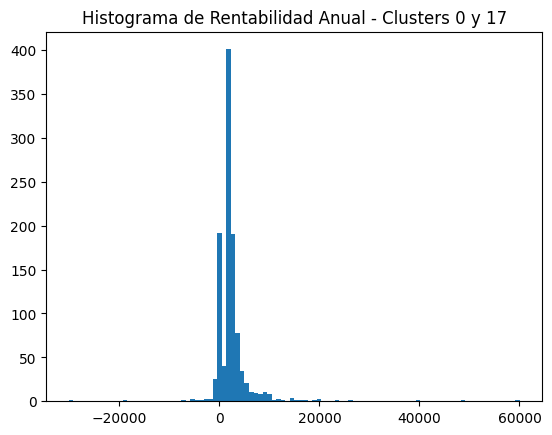

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


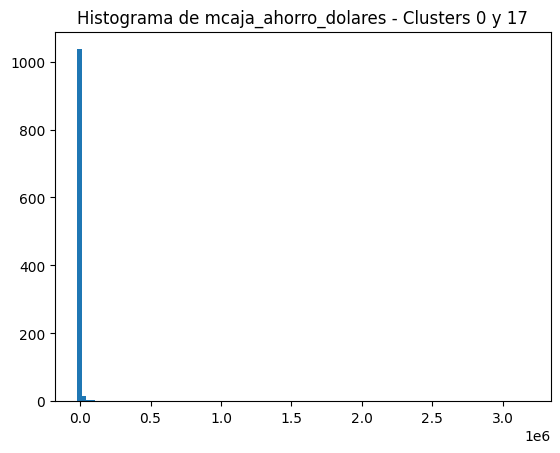

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 3)]

Xtrain_rf_imp_cluster3.describe().T



numero_de_cliente  foto_mes  active_quarter  cliente_vip    internet  \
count       3.470000e+02     347.0      347.000000        347.0  347.000000   
mean        8.401760e+08  202104.0        0.956772          0.0    0.080692   
std         3.229861e+08       0.0        0.203663          0.0    0.321398   
min         2.524540e+08  202104.0        0.000000          0.0    0.000000   
25%         5.987226e+08  202104.0        1.000000          0.0    0.000000   
50%         8.452830e+08  202104.0        1.000000          0.0    0.000000   
75%         1.082510e+09  202104.0        1.000000          0.0    0.000000   
max         1.557339e+09  202104.0        1.000000          0.0    2.000000   

       cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
count    347.000000          347.000000     347.000000            347.000000   
mean      49.020173           96.962536     778.537205           5981.057118   
std       12.864664           76.171174    2472.159911          20228.095725   
min       21.000000            2.000000  -10721.820000         -88663.590000   
25%       39.000000           41.000000     -78.080000          -1639.200000   
50%       48.000000           72.000000     941.440000           3162.260000   
75%       59.000000          139.500000    1980.180000          12578.480000   
max       82.000000          376.000000   20009.040000         197526.470000   

       mcomisiones  ...  \
count   347.000000  ...   
mean   1211.081643  ...   
std    1205.092474  ...   
min   -4713.950000  ...   
25%     160.865000  ...   
50%    1592.200000  ...   
75%    2042.940000  ...   
max    5967.410000  ...   

       ratio_mtransferencias_recibidas_mtransferencias_emitidas  \
count                                         347.000000          
mean                                           51.595299          
std                                           933.554321          
min                                             0.000000          
25%                                             1.495924          
50%                                             1.495924          
75%                                             1.495924          
max                                         17391.666667          

       ratio_mttarjeta_master_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                     
mean                                            0.049999                     
std                                             0.830112                     
min                                             0.000000                     
25%                                             0.000000                     
50%                                             0.000000                     
75%                                             0.000000                     
max                                            15.387458                     

       ratio_mtransferencias_emitidas_mttarjeta_visa_debitos_automaticos  \
count                                         347.000000                   
mean                                            0.615258                   
std                                             0.664527                   
min                                             0.000000                   
25%                                             0.000000                   
50%                                             0.028475                   
75%                                             1.212098                   
max                                             5.717091                   

       ratio_mttarjeta_visa_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                   
mean                                            0.164953                   
std                                             1.885002                   
min                               

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

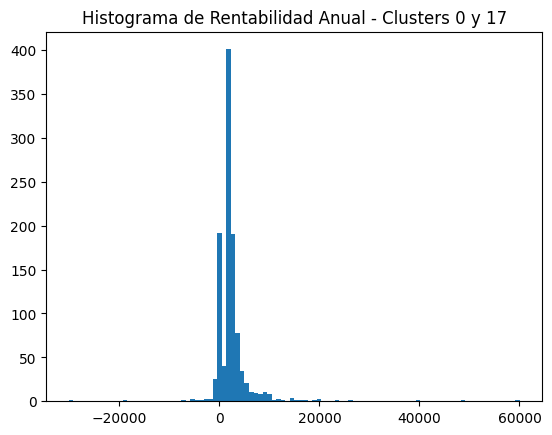

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


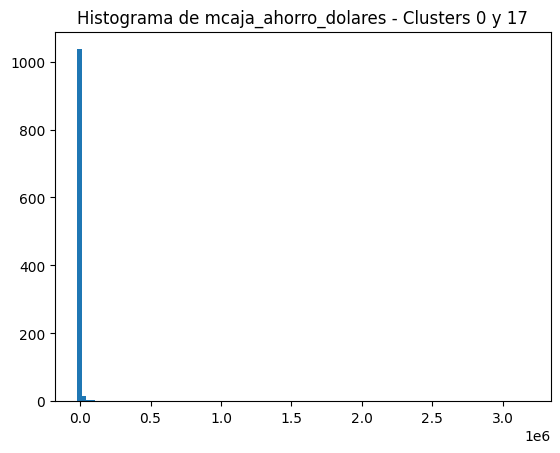

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll', 24)

Cluster 24  Rest of Clusters
count       336.000000      1.174900e+04
mean       1609.198810      6.709650e+04
std       11420.571989      2.199105e+05
min           0.000000      0.000000e+00
25%           0.000000      0.000000e+00
50%           0.000000      0.000000e+00
75%           0.000000      9.945486e+04
max      124338.000000      1.605681e+07
unique       11.000000      5.349000e+03
missing       0.000000      0.000000e+00

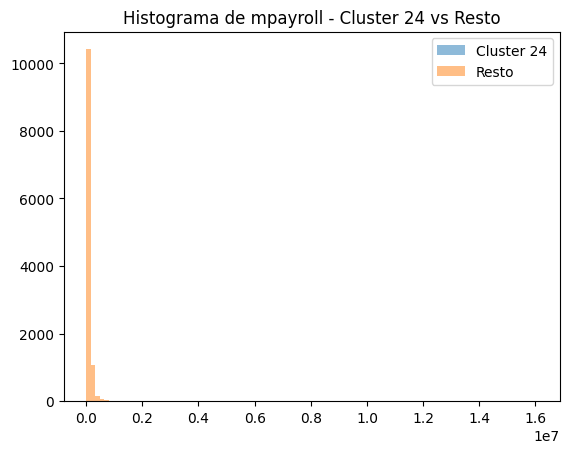

In [ ]:
# histograma comparando mpayroll de cluster 24 vs resto
plt.hist(Xtrain_rf_imp_cluster3["mpayroll"], bins=100, alpha=0.5, label='Cluster 24')
plt.hist(Xtrain_rf_imp[ Xtrain_rf_imp["cluster_25"] != 24]["mpayroll"], bins=100, alpha=0.5, label='Resto')
plt.title("Histograma de mpayroll - Cluster 24 vs Resto")
plt.legend()
plt.show()

In [125]:
Xtrain_rf["clusters_25"].value_counts()

KeyError: 'clusters_25'

In [ ]:
# analizo cluster 24, que lo diferencia de los demas

# separador de miles para todo


for i in important_features_by_cluster[0]:
    print(f"' {i} ' - Cluster 0 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf_imp, clusters, i, 0).round(0).style.format("{:,.0f}"))

' cluster ' - Cluster 0 vs. Rest


' slope_ctrx_quarter_window ' - Cluster 0 vs. Rest


' ctrx_quarter ' - Cluster 0 vs. Rest


' mtarjeta_visa_consumo ' - Cluster 0 vs. Rest


' mpasivos_margen ' - Cluster 0 vs. Rest


' mcaja_ahorro ' - Cluster 0 vs. Rest


' slope_mcaja_ahorro_window ' - Cluster 0 vs. Rest


' slope_mpasivos_margen_window ' - Cluster 0 vs. Rest


' slope_TC_Total_mconsumototal_window ' - Cluster 0 vs. Rest


' ctrx_quarter_lag_1 ' - Cluster 0 vs. Rest


' TC_Total_mpagospesos ' - Cluster 0 vs. Rest


' mcaja_ahorro_lag_1 ' - Cluster 0 vs. Rest


' slope_ctarjeta_visa_transacciones_window ' - Cluster 0 vs. Rest


' TC_Total_msaldototal_lag_1 ' - Cluster 0 vs. Rest


' mautoservicio ' - Cluster 0 vs. Rest


In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 24)]

Xtrain_rf_imp_cluster3.describe().T



count          mean  \
numero_de_cliente                                   336.0  8.056638e+08   
foto_mes                                            336.0  2.021040e+05   
active_quarter                                      336.0  1.000000e+00   
cliente_vip                                         336.0  0.000000e+00   
internet                                            336.0  1.011905e-01   
...                                                   ...           ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  336.0  1.731026e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  336.0  3.075606e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...  336.0  8.773891e-02   
cluster_25                                          336.0  2.400000e+01   
mcaja_ahorro_dolares_dummy                          336.0  3.988095e-01   

                                                             std          min  \
numero_de_cliente                                   3.101561e+08  251008988.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         0.000000e+00          0.0   
internet                                            3.807280e-01          0.0   
...                                                          ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  9.430814e+01          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.987613e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  7.040902e-01          0.0   
cluster_25                                          0.000000e+00         24.0   
mcaja_ahorro_dolares_dummy                          4.903837e-01          0.0   

                                                             25%  \
numero_de_cliente                                   5.829849e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.614856e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             50%  \
numero_de_cliente                                   7.801354e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.764425e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             75%           max  
numero_de_cliente                                   1.049784e+09  1.536984e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  0.000000e+00  
internet                                            0.000000e+00  3.000000e+00  
...                                                       

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

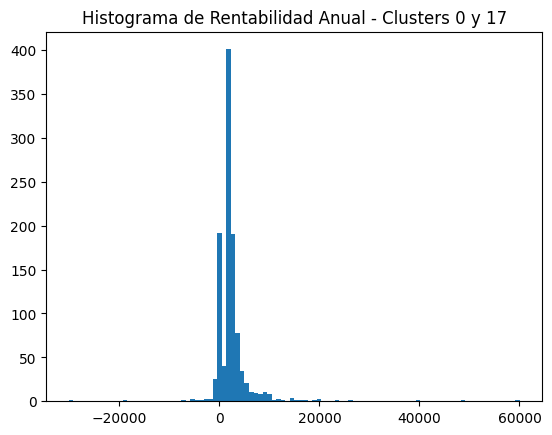

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


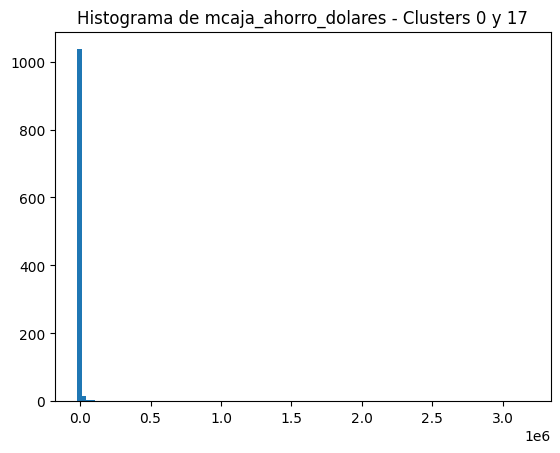

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 3)]

Xtrain_rf_imp_cluster3.describe().T



numero_de_cliente  foto_mes  active_quarter  cliente_vip    internet  \
count       3.470000e+02     347.0      347.000000        347.0  347.000000   
mean        8.401760e+08  202104.0        0.956772          0.0    0.080692   
std         3.229861e+08       0.0        0.203663          0.0    0.321398   
min         2.524540e+08  202104.0        0.000000          0.0    0.000000   
25%         5.987226e+08  202104.0        1.000000          0.0    0.000000   
50%         8.452830e+08  202104.0        1.000000          0.0    0.000000   
75%         1.082510e+09  202104.0        1.000000          0.0    0.000000   
max         1.557339e+09  202104.0        1.000000          0.0    2.000000   

       cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
count    347.000000          347.000000     347.000000            347.000000   
mean      49.020173           96.962536     778.537205           5981.057118   
std       12.864664           76.171174    2472.159911          20228.095725   
min       21.000000            2.000000  -10721.820000         -88663.590000   
25%       39.000000           41.000000     -78.080000          -1639.200000   
50%       48.000000           72.000000     941.440000           3162.260000   
75%       59.000000          139.500000    1980.180000          12578.480000   
max       82.000000          376.000000   20009.040000         197526.470000   

       mcomisiones  ...  \
count   347.000000  ...   
mean   1211.081643  ...   
std    1205.092474  ...   
min   -4713.950000  ...   
25%     160.865000  ...   
50%    1592.200000  ...   
75%    2042.940000  ...   
max    5967.410000  ...   

       ratio_mtransferencias_recibidas_mtransferencias_emitidas  \
count                                         347.000000          
mean                                           51.595299          
std                                           933.554321          
min                                             0.000000          
25%                                             1.495924          
50%                                             1.495924          
75%                                             1.495924          
max                                         17391.666667          

       ratio_mttarjeta_master_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                     
mean                                            0.049999                     
std                                             0.830112                     
min                                             0.000000                     
25%                                             0.000000                     
50%                                             0.000000                     
75%                                             0.000000                     
max                                            15.387458                     

       ratio_mtransferencias_emitidas_mttarjeta_visa_debitos_automaticos  \
count                                         347.000000                   
mean                                            0.615258                   
std                                             0.664527                   
min                                             0.000000                   
25%                                             0.000000                   
50%                                             0.028475                   
75%                                             1.212098                   
max                                             5.717091                   

       ratio_mttarjeta_visa_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                   
mean                                            0.164953                   
std                                             1.885002                   
min                               

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

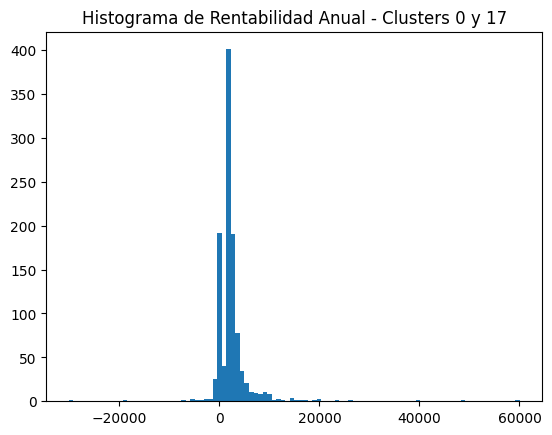

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


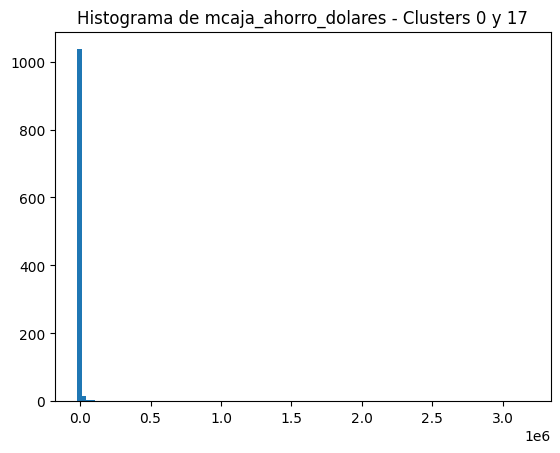

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll', 24)

Cluster 24  Rest of Clusters
count       336.000000      1.174900e+04
mean       1609.198810      6.709650e+04
std       11420.571989      2.199105e+05
min           0.000000      0.000000e+00
25%           0.000000      0.000000e+00
50%           0.000000      0.000000e+00
75%           0.000000      9.945486e+04
max      124338.000000      1.605681e+07
unique       11.000000      5.349000e+03
missing       0.000000      0.000000e+00

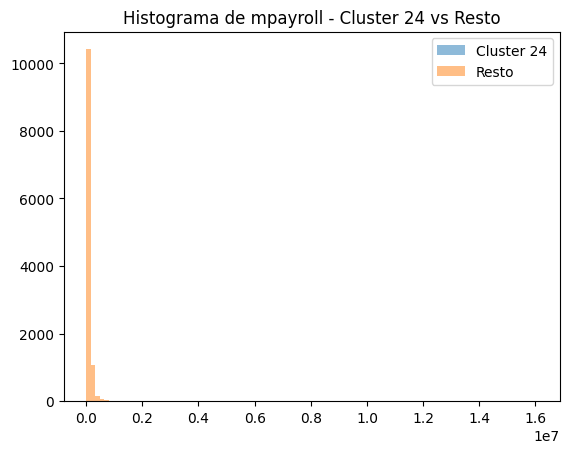

In [ ]:
# histograma comparando mpayroll de cluster 24 vs resto
plt.hist(Xtrain_rf_imp_cluster3["mpayroll"], bins=100, alpha=0.5, label='Cluster 24')
plt.hist(Xtrain_rf_imp[ Xtrain_rf_imp["cluster_25"] != 24]["mpayroll"], bins=100, alpha=0.5, label='Resto')
plt.title("Histograma de mpayroll - Cluster 24 vs Resto")
plt.legend()
plt.show()

In [104]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [105]:
# analizo cluster 24, que lo diferencia de los demas

# separador de miles para todo


for i in important_features_by_cluster[24]:
    print(f"' {i} ' - Cluster 24 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf_imp, clusters, i, 24).round(0).style.format("{:,.0f}"))

KeyError: 24

In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 24)]

Xtrain_rf_imp_cluster3.describe().T



count          mean  \
numero_de_cliente                                   336.0  8.056638e+08   
foto_mes                                            336.0  2.021040e+05   
active_quarter                                      336.0  1.000000e+00   
cliente_vip                                         336.0  0.000000e+00   
internet                                            336.0  1.011905e-01   
...                                                   ...           ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  336.0  1.731026e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  336.0  3.075606e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...  336.0  8.773891e-02   
cluster_25                                          336.0  2.400000e+01   
mcaja_ahorro_dolares_dummy                          336.0  3.988095e-01   

                                                             std          min  \
numero_de_cliente                                   3.101561e+08  251008988.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         0.000000e+00          0.0   
internet                                            3.807280e-01          0.0   
...                                                          ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  9.430814e+01          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.987613e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  7.040902e-01          0.0   
cluster_25                                          0.000000e+00         24.0   
mcaja_ahorro_dolares_dummy                          4.903837e-01          0.0   

                                                             25%  \
numero_de_cliente                                   5.829849e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.614856e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             50%  \
numero_de_cliente                                   7.801354e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.764425e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             75%           max  
numero_de_cliente                                   1.049784e+09  1.536984e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  0.000000e+00  
internet                                            0.000000e+00  3.000000e+00  
...                                                       

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

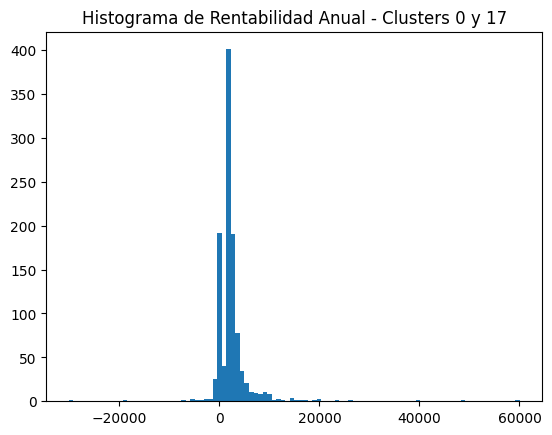

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


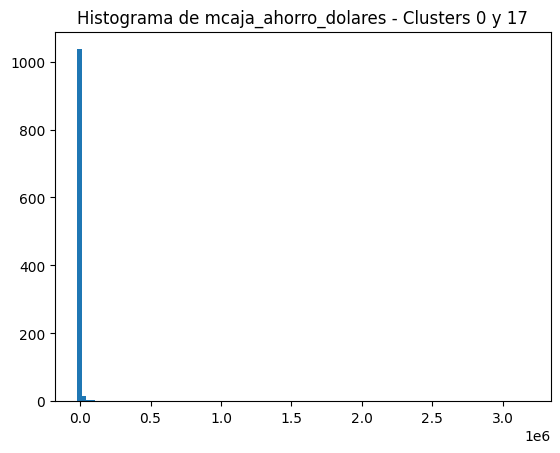

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 3)]

Xtrain_rf_imp_cluster3.describe().T



numero_de_cliente  foto_mes  active_quarter  cliente_vip    internet  \
count       3.470000e+02     347.0      347.000000        347.0  347.000000   
mean        8.401760e+08  202104.0        0.956772          0.0    0.080692   
std         3.229861e+08       0.0        0.203663          0.0    0.321398   
min         2.524540e+08  202104.0        0.000000          0.0    0.000000   
25%         5.987226e+08  202104.0        1.000000          0.0    0.000000   
50%         8.452830e+08  202104.0        1.000000          0.0    0.000000   
75%         1.082510e+09  202104.0        1.000000          0.0    0.000000   
max         1.557339e+09  202104.0        1.000000          0.0    2.000000   

       cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
count    347.000000          347.000000     347.000000            347.000000   
mean      49.020173           96.962536     778.537205           5981.057118   
std       12.864664           76.171174    2472.159911          20228.095725   
min       21.000000            2.000000  -10721.820000         -88663.590000   
25%       39.000000           41.000000     -78.080000          -1639.200000   
50%       48.000000           72.000000     941.440000           3162.260000   
75%       59.000000          139.500000    1980.180000          12578.480000   
max       82.000000          376.000000   20009.040000         197526.470000   

       mcomisiones  ...  \
count   347.000000  ...   
mean   1211.081643  ...   
std    1205.092474  ...   
min   -4713.950000  ...   
25%     160.865000  ...   
50%    1592.200000  ...   
75%    2042.940000  ...   
max    5967.410000  ...   

       ratio_mtransferencias_recibidas_mtransferencias_emitidas  \
count                                         347.000000          
mean                                           51.595299          
std                                           933.554321          
min                                             0.000000          
25%                                             1.495924          
50%                                             1.495924          
75%                                             1.495924          
max                                         17391.666667          

       ratio_mttarjeta_master_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                     
mean                                            0.049999                     
std                                             0.830112                     
min                                             0.000000                     
25%                                             0.000000                     
50%                                             0.000000                     
75%                                             0.000000                     
max                                            15.387458                     

       ratio_mtransferencias_emitidas_mttarjeta_visa_debitos_automaticos  \
count                                         347.000000                   
mean                                            0.615258                   
std                                             0.664527                   
min                                             0.000000                   
25%                                             0.000000                   
50%                                             0.028475                   
75%                                             1.212098                   
max                                             5.717091                   

       ratio_mttarjeta_visa_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                   
mean                                            0.164953                   
std                                             1.885002                   
min                               

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

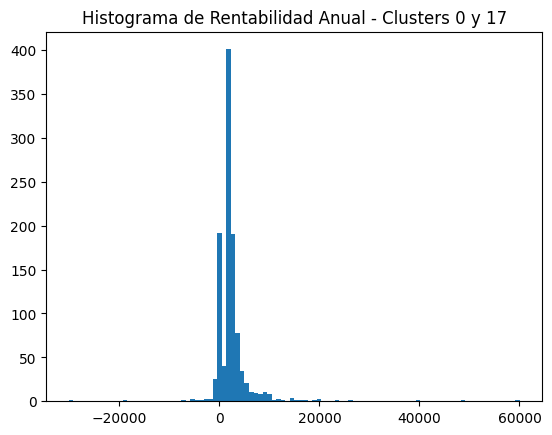

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


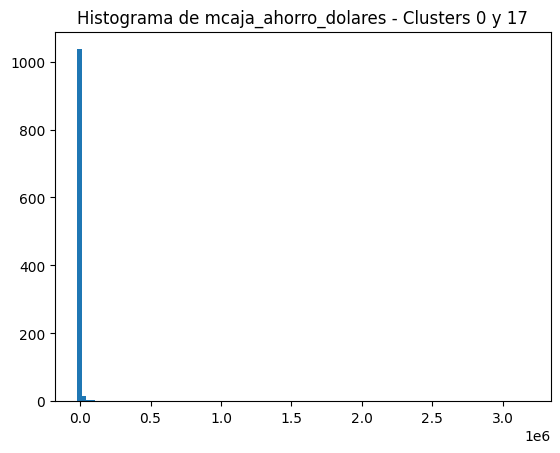

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll', 24)

Cluster 24  Rest of Clusters
count       336.000000      1.174900e+04
mean       1609.198810      6.709650e+04
std       11420.571989      2.199105e+05
min           0.000000      0.000000e+00
25%           0.000000      0.000000e+00
50%           0.000000      0.000000e+00
75%           0.000000      9.945486e+04
max      124338.000000      1.605681e+07
unique       11.000000      5.349000e+03
missing       0.000000      0.000000e+00

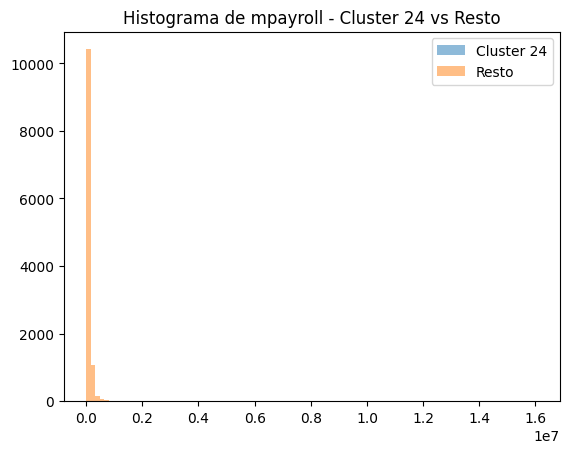

In [ ]:
# histograma comparando mpayroll de cluster 24 vs resto
plt.hist(Xtrain_rf_imp_cluster3["mpayroll"], bins=100, alpha=0.5, label='Cluster 24')
plt.hist(Xtrain_rf_imp[ Xtrain_rf_imp["cluster_25"] != 24]["mpayroll"], bins=100, alpha=0.5, label='Resto')
plt.title("Histograma de mpayroll - Cluster 24 vs Resto")
plt.legend()
plt.show()

In [272]:
# analizo cluster 3, que lo diferencia de los demas

# separador de miles para todo


for i in important_features_by_cluster[3]:
    print(f"' {i} ' - Cluster 3 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf, clusters, i, 3).round(0).style.format("{:,.0f}"))

' ctrx_quarter ' - Cluster 3 vs. Rest


' slope_mcaja_ahorro_window ' - Cluster 3 vs. Rest


' ctrx_quarter_lag_1 ' - Cluster 3 vs. Rest


' ctarjeta_debito_transacciones ' - Cluster 3 vs. Rest


' ratio_mautoservicio_mpasivos_margen ' - Cluster 3 vs. Rest


' slope_mtransferencias_emitidas_window ' - Cluster 3 vs. Rest


' slope_ctrx_quarter_window ' - Cluster 3 vs. Rest


' slope_mcuentas_saldo_window ' - Cluster 3 vs. Rest


' mcuentas_saldo ' - Cluster 3 vs. Rest


' mcaja_ahorro ' - Cluster 3 vs. Rest


' ctarjeta_debito_transacciones_lag_1 ' - Cluster 3 vs. Rest


' mautoservicio_lag_1 ' - Cluster 3 vs. Rest


' slope_mpagomiscuentas_window ' - Cluster 3 vs. Rest


' ratio_mtransferencias_emitidas_mpasivos_margen ' - Cluster 3 vs. Rest


' ratio_mtransferencias_emitidas_mtarjeta_visa_consumo ' - Cluster 3 vs. Rest


In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 24)]

Xtrain_rf_imp_cluster3.describe().T



count          mean  \
numero_de_cliente                                   336.0  8.056638e+08   
foto_mes                                            336.0  2.021040e+05   
active_quarter                                      336.0  1.000000e+00   
cliente_vip                                         336.0  0.000000e+00   
internet                                            336.0  1.011905e-01   
...                                                   ...           ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  336.0  1.731026e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  336.0  3.075606e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...  336.0  8.773891e-02   
cluster_25                                          336.0  2.400000e+01   
mcaja_ahorro_dolares_dummy                          336.0  3.988095e-01   

                                                             std          min  \
numero_de_cliente                                   3.101561e+08  251008988.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         0.000000e+00          0.0   
internet                                            3.807280e-01          0.0   
...                                                          ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  9.430814e+01          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.987613e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  7.040902e-01          0.0   
cluster_25                                          0.000000e+00         24.0   
mcaja_ahorro_dolares_dummy                          4.903837e-01          0.0   

                                                             25%  \
numero_de_cliente                                   5.829849e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.614856e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             50%  \
numero_de_cliente                                   7.801354e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.764425e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             75%           max  
numero_de_cliente                                   1.049784e+09  1.536984e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  0.000000e+00  
internet                                            0.000000e+00  3.000000e+00  
...                                                       

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

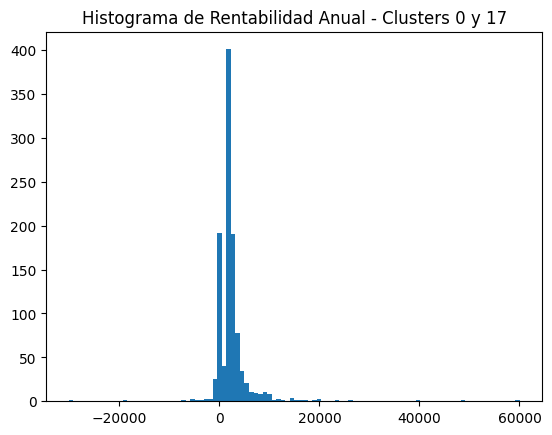

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


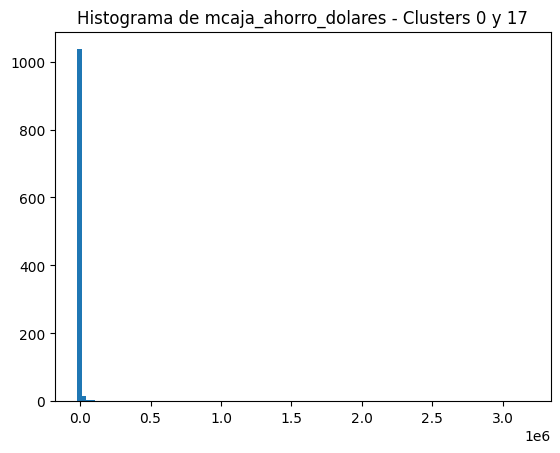

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 3)]

Xtrain_rf_imp_cluster3.describe().T



numero_de_cliente  foto_mes  active_quarter  cliente_vip    internet  \
count       3.470000e+02     347.0      347.000000        347.0  347.000000   
mean        8.401760e+08  202104.0        0.956772          0.0    0.080692   
std         3.229861e+08       0.0        0.203663          0.0    0.321398   
min         2.524540e+08  202104.0        0.000000          0.0    0.000000   
25%         5.987226e+08  202104.0        1.000000          0.0    0.000000   
50%         8.452830e+08  202104.0        1.000000          0.0    0.000000   
75%         1.082510e+09  202104.0        1.000000          0.0    0.000000   
max         1.557339e+09  202104.0        1.000000          0.0    2.000000   

       cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
count    347.000000          347.000000     347.000000            347.000000   
mean      49.020173           96.962536     778.537205           5981.057118   
std       12.864664           76.171174    2472.159911          20228.095725   
min       21.000000            2.000000  -10721.820000         -88663.590000   
25%       39.000000           41.000000     -78.080000          -1639.200000   
50%       48.000000           72.000000     941.440000           3162.260000   
75%       59.000000          139.500000    1980.180000          12578.480000   
max       82.000000          376.000000   20009.040000         197526.470000   

       mcomisiones  ...  \
count   347.000000  ...   
mean   1211.081643  ...   
std    1205.092474  ...   
min   -4713.950000  ...   
25%     160.865000  ...   
50%    1592.200000  ...   
75%    2042.940000  ...   
max    5967.410000  ...   

       ratio_mtransferencias_recibidas_mtransferencias_emitidas  \
count                                         347.000000          
mean                                           51.595299          
std                                           933.554321          
min                                             0.000000          
25%                                             1.495924          
50%                                             1.495924          
75%                                             1.495924          
max                                         17391.666667          

       ratio_mttarjeta_master_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                     
mean                                            0.049999                     
std                                             0.830112                     
min                                             0.000000                     
25%                                             0.000000                     
50%                                             0.000000                     
75%                                             0.000000                     
max                                            15.387458                     

       ratio_mtransferencias_emitidas_mttarjeta_visa_debitos_automaticos  \
count                                         347.000000                   
mean                                            0.615258                   
std                                             0.664527                   
min                                             0.000000                   
25%                                             0.000000                   
50%                                             0.028475                   
75%                                             1.212098                   
max                                             5.717091                   

       ratio_mttarjeta_visa_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                   
mean                                            0.164953                   
std                                             1.885002                   
min                               

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

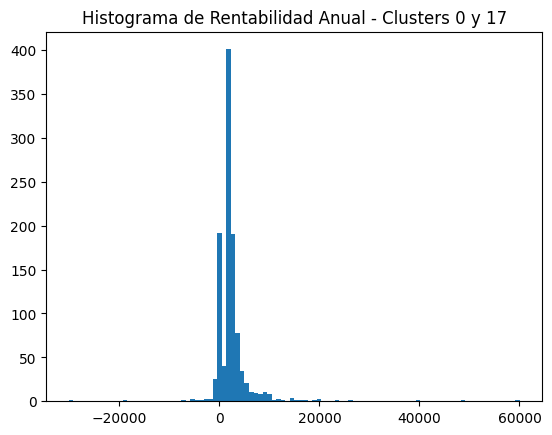

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


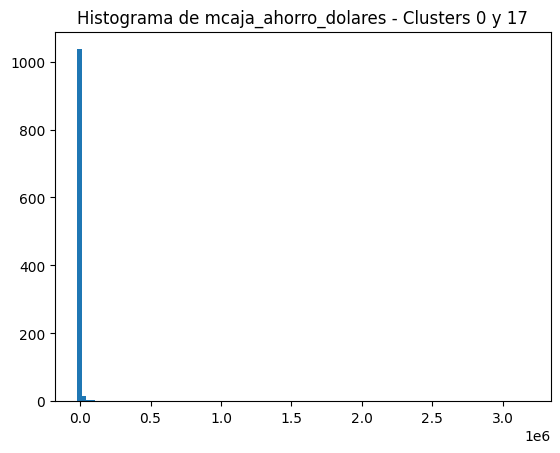

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll', 24)

Cluster 24  Rest of Clusters
count       336.000000      1.174900e+04
mean       1609.198810      6.709650e+04
std       11420.571989      2.199105e+05
min           0.000000      0.000000e+00
25%           0.000000      0.000000e+00
50%           0.000000      0.000000e+00
75%           0.000000      9.945486e+04
max      124338.000000      1.605681e+07
unique       11.000000      5.349000e+03
missing       0.000000      0.000000e+00

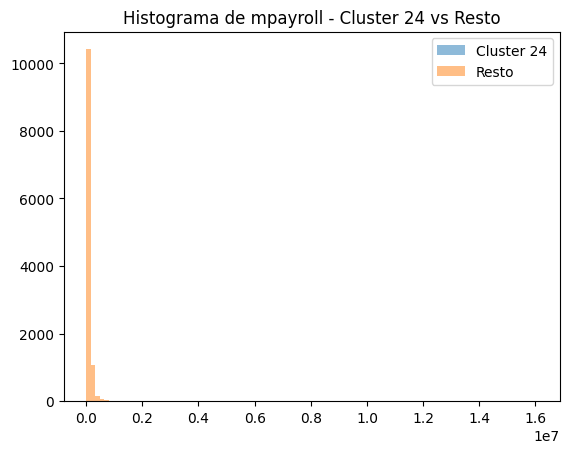

In [ ]:
# histograma comparando mpayroll de cluster 24 vs resto
plt.hist(Xtrain_rf_imp_cluster3["mpayroll"], bins=100, alpha=0.5, label='Cluster 24')
plt.hist(Xtrain_rf_imp[ Xtrain_rf_imp["cluster_25"] != 24]["mpayroll"], bins=100, alpha=0.5, label='Resto')
plt.title("Histograma de mpayroll - Cluster 24 vs Resto")
plt.legend()
plt.show()

In [273]:
important_features_by_cluster = {}
N = 30  # cantidad de features a guardar por cluster

for cluster in sorted(np.unique(clusters)):
    print(f"Training model for Cluster {cluster} vs. Rest...")
    y_binary = (cluster_series_aligned == cluster).astype(int)

    model = RandomForestClassifier(
        n_estimators=100,
        random_state=17,
        class_weight='balanced'
    )
    model.fit(Xtrain_rf_imp, y_binary)

    importances = model.feature_importances_
    feature_names = Xtrain_rf.columns

    indices = np.argsort(importances)[::-1]
    important_features_by_cluster[cluster] = [feature_names[i] for i in indices[:N]]

Training model for Cluster 0 vs. Rest...


IndexError: index 1648 is out of bounds for axis 0 with size 1648

In [116]:
# analizo cluster 24, que lo diferencia de los demas

# separador de miles para todo


for i in important_features_by_cluster[1]:
    print(f"' {i} ' - Cluster 0 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf_imp, clusters, i, 0).round(0).style.format("{:,.0f}"))

' cluster ' - Cluster 0 vs. Rest


KeyError: 'cluster'

In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 24)]

Xtrain_rf_imp_cluster3.describe().T



count          mean  \
numero_de_cliente                                   336.0  8.056638e+08   
foto_mes                                            336.0  2.021040e+05   
active_quarter                                      336.0  1.000000e+00   
cliente_vip                                         336.0  0.000000e+00   
internet                                            336.0  1.011905e-01   
...                                                   ...           ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  336.0  1.731026e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  336.0  3.075606e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...  336.0  8.773891e-02   
cluster_25                                          336.0  2.400000e+01   
mcaja_ahorro_dolares_dummy                          336.0  3.988095e-01   

                                                             std          min  \
numero_de_cliente                                   3.101561e+08  251008988.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         0.000000e+00          0.0   
internet                                            3.807280e-01          0.0   
...                                                          ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  9.430814e+01          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.987613e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  7.040902e-01          0.0   
cluster_25                                          0.000000e+00         24.0   
mcaja_ahorro_dolares_dummy                          4.903837e-01          0.0   

                                                             25%  \
numero_de_cliente                                   5.829849e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.614856e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             50%  \
numero_de_cliente                                   7.801354e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.764425e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             75%           max  
numero_de_cliente                                   1.049784e+09  1.536984e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  0.000000e+00  
internet                                            0.000000e+00  3.000000e+00  
...                                                       

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

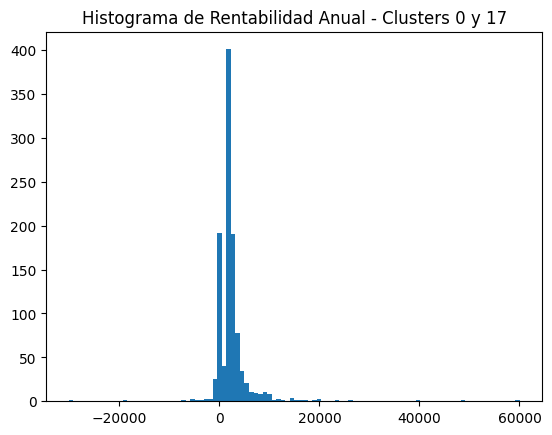

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


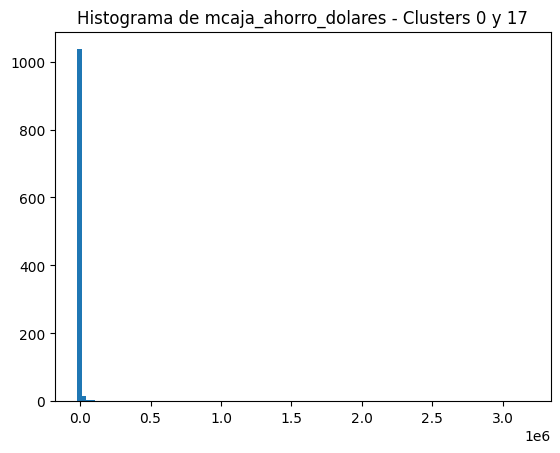

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 3)]

Xtrain_rf_imp_cluster3.describe().T



numero_de_cliente  foto_mes  active_quarter  cliente_vip    internet  \
count       3.470000e+02     347.0      347.000000        347.0  347.000000   
mean        8.401760e+08  202104.0        0.956772          0.0    0.080692   
std         3.229861e+08       0.0        0.203663          0.0    0.321398   
min         2.524540e+08  202104.0        0.000000          0.0    0.000000   
25%         5.987226e+08  202104.0        1.000000          0.0    0.000000   
50%         8.452830e+08  202104.0        1.000000          0.0    0.000000   
75%         1.082510e+09  202104.0        1.000000          0.0    0.000000   
max         1.557339e+09  202104.0        1.000000          0.0    2.000000   

       cliente_edad  cliente_antiguedad  mrentabilidad  mrentabilidad_annual  \
count    347.000000          347.000000     347.000000            347.000000   
mean      49.020173           96.962536     778.537205           5981.057118   
std       12.864664           76.171174    2472.159911          20228.095725   
min       21.000000            2.000000  -10721.820000         -88663.590000   
25%       39.000000           41.000000     -78.080000          -1639.200000   
50%       48.000000           72.000000     941.440000           3162.260000   
75%       59.000000          139.500000    1980.180000          12578.480000   
max       82.000000          376.000000   20009.040000         197526.470000   

       mcomisiones  ...  \
count   347.000000  ...   
mean   1211.081643  ...   
std    1205.092474  ...   
min   -4713.950000  ...   
25%     160.865000  ...   
50%    1592.200000  ...   
75%    2042.940000  ...   
max    5967.410000  ...   

       ratio_mtransferencias_recibidas_mtransferencias_emitidas  \
count                                         347.000000          
mean                                           51.595299          
std                                           933.554321          
min                                             0.000000          
25%                                             1.495924          
50%                                             1.495924          
75%                                             1.495924          
max                                         17391.666667          

       ratio_mttarjeta_master_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                     
mean                                            0.049999                     
std                                             0.830112                     
min                                             0.000000                     
25%                                             0.000000                     
50%                                             0.000000                     
75%                                             0.000000                     
max                                            15.387458                     

       ratio_mtransferencias_emitidas_mttarjeta_visa_debitos_automaticos  \
count                                         347.000000                   
mean                                            0.615258                   
std                                             0.664527                   
min                                             0.000000                   
25%                                             0.000000                   
50%                                             0.028475                   
75%                                             1.212098                   
max                                             5.717091                   

       ratio_mttarjeta_visa_debitos_automaticos_mtransferencias_emitidas  \
count                                         347.000000                   
mean                                            0.164953                   
std                                             1.885002                   
min                               

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

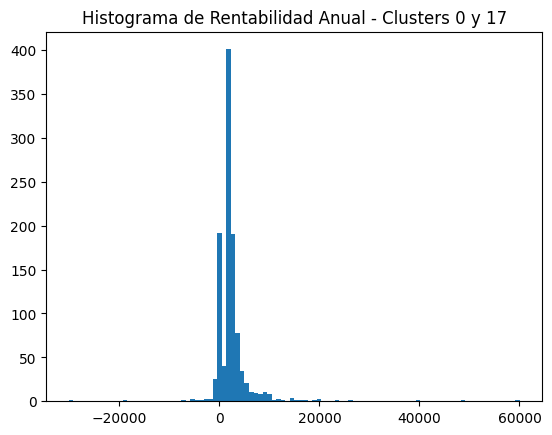

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


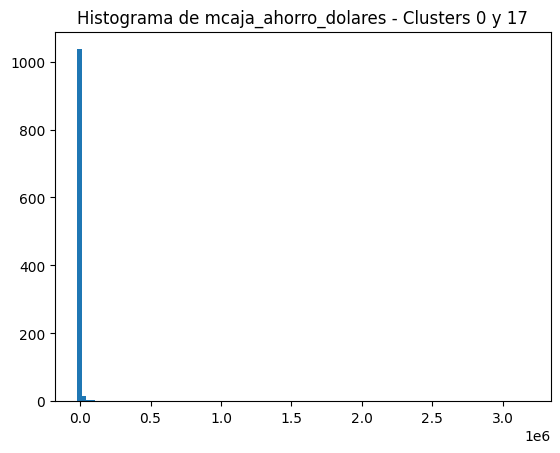

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll', 24)

Cluster 24  Rest of Clusters
count       336.000000      1.174900e+04
mean       1609.198810      6.709650e+04
std       11420.571989      2.199105e+05
min           0.000000      0.000000e+00
25%           0.000000      0.000000e+00
50%           0.000000      0.000000e+00
75%           0.000000      9.945486e+04
max      124338.000000      1.605681e+07
unique       11.000000      5.349000e+03
missing       0.000000      0.000000e+00

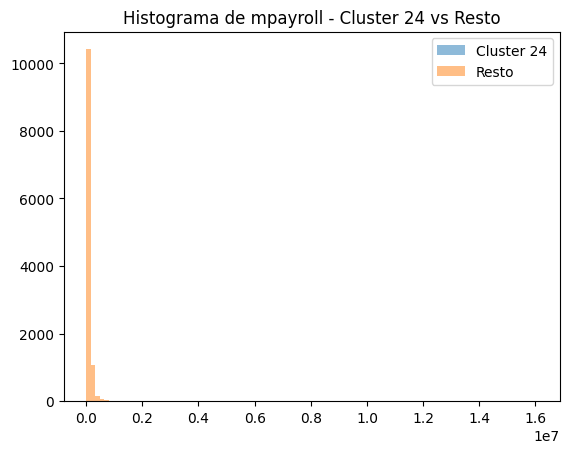

In [ ]:
# histograma comparando mpayroll de cluster 24 vs resto
plt.hist(Xtrain_rf_imp_cluster3["mpayroll"], bins=100, alpha=0.5, label='Cluster 24')
plt.hist(Xtrain_rf_imp[ Xtrain_rf_imp["cluster_25"] != 24]["mpayroll"], bins=100, alpha=0.5, label='Resto')
plt.title("Histograma de mpayroll - Cluster 24 vs Resto")
plt.legend()
plt.show()

In [274]:
# analizo cluster 3, que lo diferencia de los demas

# separador de miles para todo


for i in important_features_by_cluster[3]:
    print(f"' {i} ' - Cluster 3 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf, clusters, i, 3).round(0).style.format("{:,.0f}"))

KeyError: 3

In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 24)]

Xtrain_rf_imp_cluster3.describe().T



count          mean  \
numero_de_cliente                                   336.0  8.056638e+08   
foto_mes                                            336.0  2.021040e+05   
active_quarter                                      336.0  1.000000e+00   
cliente_vip                                         336.0  0.000000e+00   
internet                                            336.0  1.011905e-01   
...                                                   ...           ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  336.0  1.731026e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  336.0  3.075606e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...  336.0  8.773891e-02   
cluster_25                                          336.0  2.400000e+01   
mcaja_ahorro_dolares_dummy                          336.0  3.988095e-01   

                                                             std          min  \
numero_de_cliente                                   3.101561e+08  251008988.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         0.000000e+00          0.0   
internet                                            3.807280e-01          0.0   
...                                                          ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  9.430814e+01          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.987613e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  7.040902e-01          0.0   
cluster_25                                          0.000000e+00         24.0   
mcaja_ahorro_dolares_dummy                          4.903837e-01          0.0   

                                                             25%  \
numero_de_cliente                                   5.829849e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.614856e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             50%  \
numero_de_cliente                                   7.801354e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.764425e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.400000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             75%           max  
numero_de_cliente                                   1.049784e+09  1.536984e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  0.000000e+00  
internet                                            0.000000e+00  3.000000e+00  
...                                                       

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

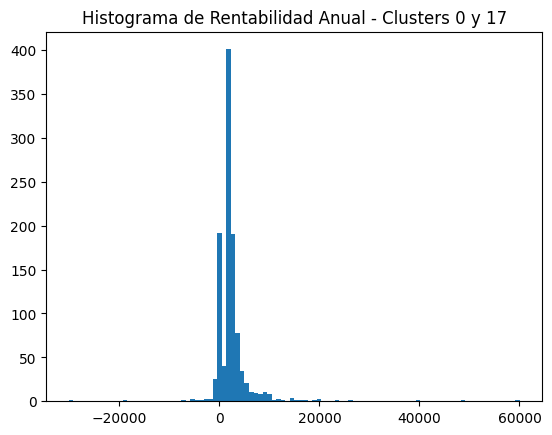

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


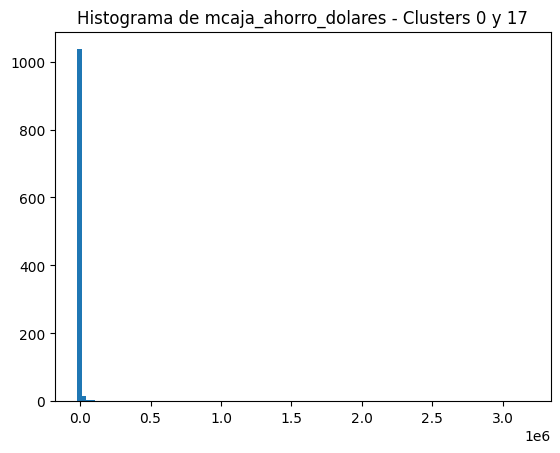

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
# quiero ver los descriptivos de los individuos quue tienen mplazo_fijo_dolares > 0

Xtrain_rf_ind_pf_dolares = Xtrain_rf[Xtrain_rf["mplazo_fijo_dolares"] > 0]
Xtrain_rf_ind_pf_dolares.describe().T

count          mean  \
numero_de_cliente                                   1350.0  6.987234e+08   
foto_mes                                            1350.0  2.021040e+05   
active_quarter                                      1350.0  1.000000e+00   
cliente_vip                                         1350.0  8.888889e-03   
internet                                            1350.0  7.407407e-03   
...                                                    ...           ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  1019.0  6.311052e-02   
ratio_mtransferencias_recibidas_mttarjeta_visa_...   943.0  7.309510e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1019.0  4.004449e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...   943.0  3.757231e-01   
cluster                                             1350.0  7.007407e-01   

                                                             std          min  \
numero_de_cliente                                   3.055335e+08  249803647.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         9.389573e-02          0.0   
internet                                            9.402429e-02          0.0   
...                                                          ...          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  7.954749e-01          0.0   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  3.964063e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.734083e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.337514e+00          0.0   
cluster                                             8.501948e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.749595e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.873471e-01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.492102e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mttarjeta_master_debitos_automaticos_mtra...  0.000000e+00   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.489430e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  3.718032e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster                                             1.000000e+00   

                                                             75%           max  
numero_de_cliente                                   8.983182e+08  1.556496e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  2.000000e+00  
...                                            

In [ ]:
Xtrain_rf_imp["cluster_25"].value_counts()

cluster_25
5     937
9     838
22    660
21    632
16    587
17    565
1     563
19    556
18    538
4     535
2     517
0     503
23    480
20    462
15    451
11    394
8     375
3     347
6     340
24    336
7     319
14    316
12    300
10    267
13    267
Name: count, dtype: int64

# Cluster 23

# Cluster 10

# Cluster 6

In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 6)]

Xtrain_rf_imp_cluster3.describe().T



count          mean  \
numero_de_cliente                                   340.0  8.348712e+08   
foto_mes                                            340.0  2.021040e+05   
active_quarter                                      340.0  1.000000e+00   
cliente_vip                                         340.0  2.941176e-03   
internet                                            340.0  1.911765e-01   
...                                                   ...           ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  340.0  1.771306e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  340.0  3.229618e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  340.0  2.268266e-01   
cluster_25                                          340.0  6.000000e+00   
mcaja_ahorro_dolares_dummy                          340.0  4.441176e-01   

                                                             std          min  \
numero_de_cliente                                   3.410328e+08  255573058.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      0.000000e+00          1.0   
cliente_vip                                         5.423261e-02          0.0   
internet                                            5.659292e-01          0.0   
...                                                          ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  1.004374e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  1.785656e-01          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.532258e+00          0.0   
cluster_25                                          0.000000e+00          6.0   
mcaja_ahorro_dolares_dummy                          4.975997e-01          0.0   

                                                             25%  \
numero_de_cliente                                   5.733224e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          6.000000e+00   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             50%  \
numero_de_cliente                                   7.863482e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          6.000000e+00   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             75%           max  
numero_de_cliente                                   1.097863e+09  1.583526e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  3.000000e+00  
...                                                       

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

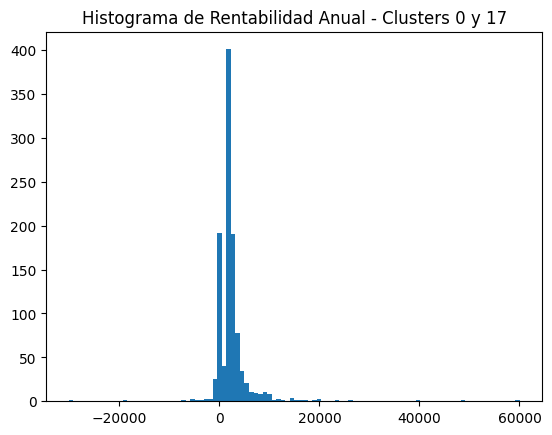

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


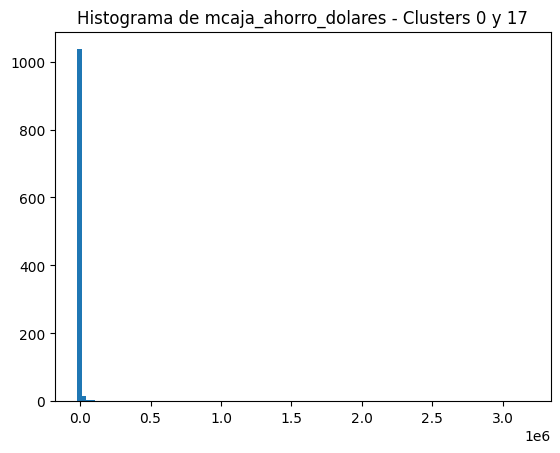

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [134]:
compare_cluster_stats(Xtrain_rf_imp, clusters, 'cliente_antiguedad', 3)

Cluster 3  Rest of Clusters
count       347.00          11738.00
mean         96.96            130.56
std          76.17             85.57
min           2.00              1.00
25%          41.00             59.00
50%          72.00            122.00
75%         139.50            186.00
max         376.00            376.00
unique      176.00            324.00
missing       0.00              0.00

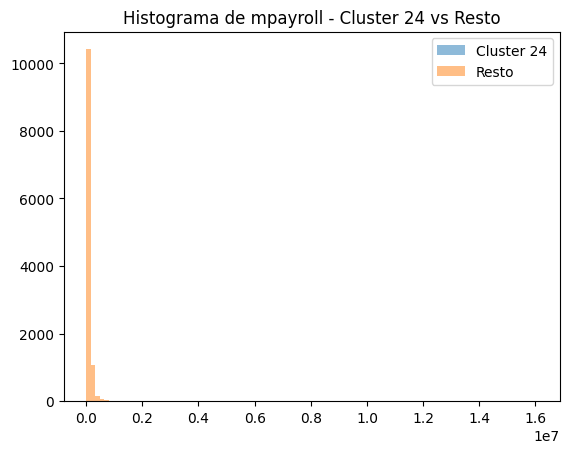

In [ ]:
# histograma comparando mpayroll de cluster 24 vs resto
plt.hist(Xtrain_rf_imp_cluster3["mpayroll"], bins=100, alpha=0.5, label='Cluster 24')
plt.hist(Xtrain_rf_imp[ Xtrain_rf_imp["cluster_25"] != 24]["mpayroll"], bins=100, alpha=0.5, label='Resto')
plt.title("Histograma de mpayroll - Cluster 24 vs Resto")
plt.legend()
plt.show()

In [ ]:
# analizo cluster 6, que lo diferencia de los demas

# separador de miles para todo


for i in important_features_by_cluster[6]:
    print(f"' {i} ' - Cluster 6 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf, clusters, i, 6).round(0).style.format("{:,.0f}"))

' mtarjeta_visa_consumo ' - Cluster 6 vs. Rest


' ctarjeta_visa_transacciones ' - Cluster 6 vs. Rest


' ctrx_quarter ' - Cluster 6 vs. Rest


' ratio_mpayroll_mcaja_ahorro ' - Cluster 6 vs. Rest


' slope_ctrx_quarter_window ' - Cluster 6 vs. Rest


' ratio_mtarjeta_visa_consumo_mcomisiones ' - Cluster 6 vs. Rest


' ratio_mpayroll_mcomisiones ' - Cluster 6 vs. Rest


' ctrx_quarter_lag_1 ' - Cluster 6 vs. Rest


' ratio_mpayroll_mcomisiones_otras ' - Cluster 6 vs. Rest


' mtarjeta_visa_consumo_lag_1 ' - Cluster 6 vs. Rest


' ratio_mtarjeta_visa_consumo_mtransferencias_recibidas ' - Cluster 6 vs. Rest


' ratio_mpayroll_mpasivos_margen ' - Cluster 6 vs. Rest


' TC_Total_mpagominimo ' - Cluster 6 vs. Rest


' ratio_mtarjeta_visa_consumo_mautoservicio ' - Cluster 6 vs. Rest


' TC_Total_msaldototal ' - Cluster 6 vs. Rest


In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 23)]

Xtrain_rf_imp_cluster3.describe().T



count          mean  \
numero_de_cliente                                   480.0  7.501372e+08   
foto_mes                                            480.0  2.021040e+05   
active_quarter                                      480.0  9.708333e-01   
cliente_vip                                         480.0  2.083333e-03   
internet                                            480.0  1.458333e-02   
...                                                   ...           ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  480.0  1.481924e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  480.0  3.556893e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...  480.0  9.960051e-04   
cluster_25                                          480.0  2.300000e+01   
mcaja_ahorro_dolares_dummy                          480.0  4.520833e-01   

                                                             std          min  \
numero_de_cliente                                   3.419462e+08  249794604.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      1.684491e-01          0.0   
cliente_vip                                         4.564355e-02          0.0   
internet                                            1.200028e-01          0.0   
...                                                          ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  1.378233e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  5.667065e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.182138e-02          0.0   
cluster_25                                          0.000000e+00         23.0   
mcaja_ahorro_dolares_dummy                          4.982179e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.825839e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.300000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.720784e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.764425e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.300000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             75%           max  
numero_de_cliente                                   1.014979e+09  1.582362e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  1.000000e+00  
...                                                       

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

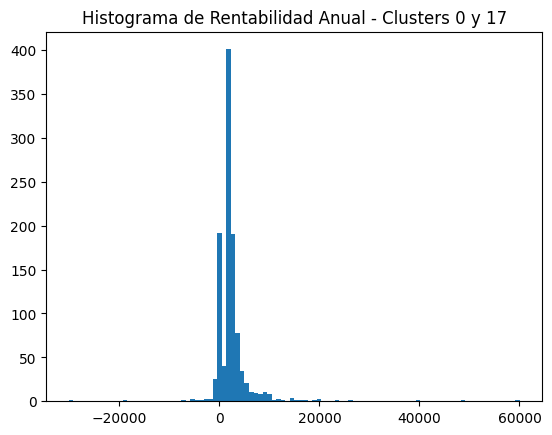

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


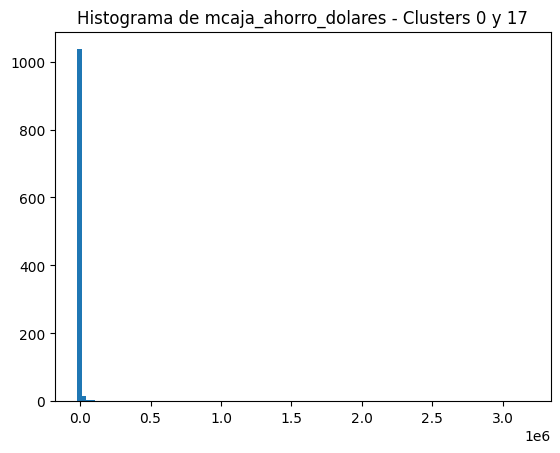

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll', 24)

Cluster 24  Rest of Clusters
count       336.000000      1.174900e+04
mean       1609.198810      6.709650e+04
std       11420.571989      2.199105e+05
min           0.000000      0.000000e+00
25%           0.000000      0.000000e+00
50%           0.000000      0.000000e+00
75%           0.000000      9.945486e+04
max      124338.000000      1.605681e+07
unique       11.000000      5.349000e+03
missing       0.000000      0.000000e+00

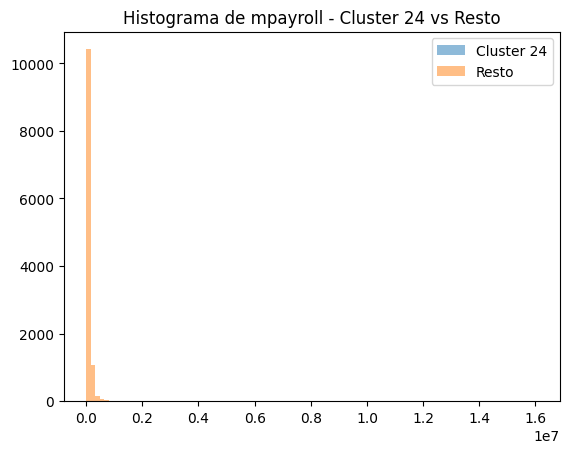

In [ ]:
# histograma comparando mpayroll de cluster 24 vs resto
plt.hist(Xtrain_rf_imp_cluster3["mpayroll"], bins=100, alpha=0.5, label='Cluster 24')
plt.hist(Xtrain_rf_imp[ Xtrain_rf_imp["cluster_25"] != 24]["mpayroll"], bins=100, alpha=0.5, label='Resto')
plt.title("Histograma de mpayroll - Cluster 24 vs Resto")
plt.legend()
plt.show()

In [ ]:
# analizo cluster 23, que lo diferencia de los demas

# separador de miles para todo


for i in important_features_by_cluster[23]:
    print(f"' {i} ' - Cluster 23 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf, clusters, i, 23).round(0).style.format("{:,.0f}"))

' ctrx_quarter ' - Cluster 23 vs. Rest


' ctrx_quarter_lag_1 ' - Cluster 23 vs. Rest


' slope_ctrx_quarter_window ' - Cluster 23 vs. Rest


' ratio_mpayroll_mcaja_ahorro ' - Cluster 23 vs. Rest


' ratio_mextraccion_autoservicio_mcaja_ahorro ' - Cluster 23 vs. Rest


' ratio_mautoservicio_mcaja_ahorro ' - Cluster 23 vs. Rest


' ctarjeta_debito_transacciones ' - Cluster 23 vs. Rest


' slope_Visa_cconsumos_window ' - Cluster 23 vs. Rest


' mautoservicio_lag_1 ' - Cluster 23 vs. Rest


' slope_ctarjeta_debito_transacciones_window ' - Cluster 23 vs. Rest


' slope_TC_Total_cconsumos_window ' - Cluster 23 vs. Rest


' TC_Total_cconsumos ' - Cluster 23 vs. Rest


' ctarjeta_debito_transacciones_lag_1 ' - Cluster 23 vs. Rest


' ratio_mautoservicio_mpasivos_margen ' - Cluster 23 vs. Rest


' mcaja_ahorro ' - Cluster 23 vs. Rest


In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 10)]

Xtrain_rf_imp_cluster3.describe().T



count          mean  \
numero_de_cliente                                   267.0  8.960632e+08   
foto_mes                                            267.0  2.021040e+05   
active_quarter                                      267.0  9.363296e-01   
cliente_vip                                         267.0  0.000000e+00   
internet                                            267.0  7.041199e-01   
...                                                   ...           ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  267.0  4.351662e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  267.0  6.933148e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  267.0  7.593569e-02   
cluster_25                                          267.0  1.000000e+01   
mcaja_ahorro_dolares_dummy                          267.0  1.985019e-01   

                                                             std          min  \
numero_de_cliente                                   3.322759e+08  252090639.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      2.446234e-01          0.0   
cliente_vip                                         0.000000e+00          0.0   
internet                                            8.749339e-01          0.0   
...                                                          ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  5.943354e+00          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  4.142549e-01          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  8.009658e-01          0.0   
cluster_25                                          0.000000e+00         10.0   
mcaja_ahorro_dolares_dummy                          3.996211e-01          0.0   

                                                             25%  \
numero_de_cliente                                   6.350918e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.764425e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          1.000000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             50%  \
numero_de_cliente                                   9.368847e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.764425e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          1.000000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             75%           max  
numero_de_cliente                                   1.178612e+09  1.589583e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  0.000000e+00  
internet                                            1.000000e+00  3.000000e+00  
...                                                       

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

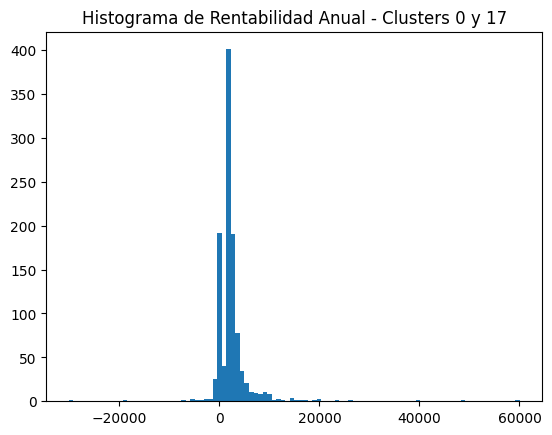

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


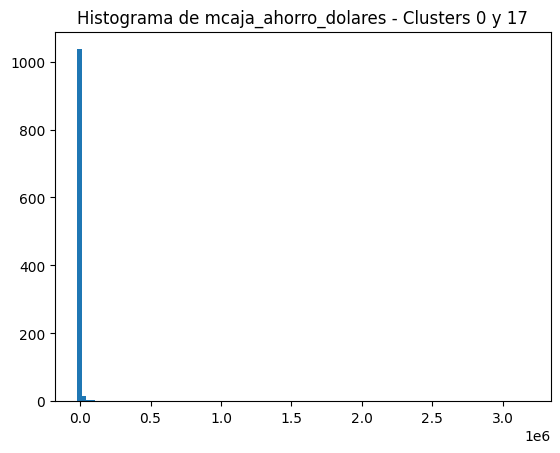

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll', 24)

Cluster 24  Rest of Clusters
count       336.000000      1.174900e+04
mean       1609.198810      6.709650e+04
std       11420.571989      2.199105e+05
min           0.000000      0.000000e+00
25%           0.000000      0.000000e+00
50%           0.000000      0.000000e+00
75%           0.000000      9.945486e+04
max      124338.000000      1.605681e+07
unique       11.000000      5.349000e+03
missing       0.000000      0.000000e+00

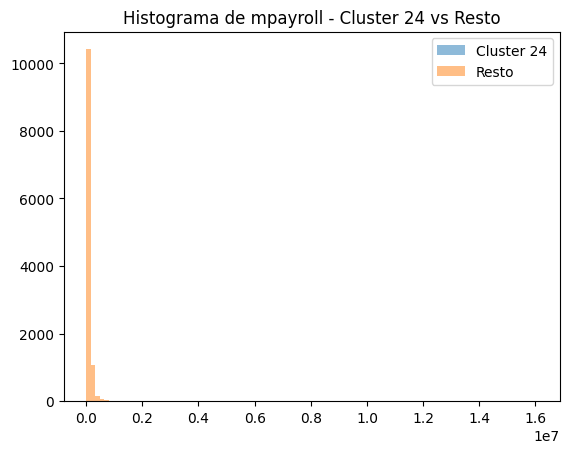

In [ ]:
# histograma comparando mpayroll de cluster 24 vs resto
plt.hist(Xtrain_rf_imp_cluster3["mpayroll"], bins=100, alpha=0.5, label='Cluster 24')
plt.hist(Xtrain_rf_imp[ Xtrain_rf_imp["cluster_25"] != 24]["mpayroll"], bins=100, alpha=0.5, label='Resto')
plt.title("Histograma de mpayroll - Cluster 24 vs Resto")
plt.legend()
plt.show()

In [265]:
# analizo cluster 3, que lo diferencia de los demas

# separador de miles para todo


for i in important_features_by_cluster[3]:
    print(f"' {i} ' - Cluster 3 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf, clusters, i, 3).round(0).style.format("{:,.0f}"))

' ctrx_quarter ' - Cluster 3 vs. Rest


' slope_mcaja_ahorro_window ' - Cluster 3 vs. Rest


' ctrx_quarter_lag_1 ' - Cluster 3 vs. Rest


' ctarjeta_debito_transacciones ' - Cluster 3 vs. Rest


' ratio_mautoservicio_mpasivos_margen ' - Cluster 3 vs. Rest


' slope_mtransferencias_emitidas_window ' - Cluster 3 vs. Rest


' slope_ctrx_quarter_window ' - Cluster 3 vs. Rest


' slope_mcuentas_saldo_window ' - Cluster 3 vs. Rest


' mcuentas_saldo ' - Cluster 3 vs. Rest


' mcaja_ahorro ' - Cluster 3 vs. Rest


' ctarjeta_debito_transacciones_lag_1 ' - Cluster 3 vs. Rest


' mautoservicio_lag_1 ' - Cluster 3 vs. Rest


' slope_mpagomiscuentas_window ' - Cluster 3 vs. Rest


' ratio_mtransferencias_emitidas_mpasivos_margen ' - Cluster 3 vs. Rest


' ratio_mtransferencias_emitidas_mtarjeta_visa_consumo ' - Cluster 3 vs. Rest


In [ ]:
Xtrain_rf_imp_cluster3 = Xtrain_rf_imp[ (Xtrain_rf_imp["cluster_25"] == 23)]

Xtrain_rf_imp_cluster3.describe().T



count          mean  \
numero_de_cliente                                   480.0  7.501372e+08   
foto_mes                                            480.0  2.021040e+05   
active_quarter                                      480.0  9.708333e-01   
cliente_vip                                         480.0  2.083333e-03   
internet                                            480.0  1.458333e-02   
...                                                   ...           ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  480.0  1.481924e+01   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  480.0  3.556893e-01   
ratio_mttarjeta_master_debitos_automaticos_mtta...  480.0  9.960051e-04   
cluster_25                                          480.0  2.300000e+01   
mcaja_ahorro_dolares_dummy                          480.0  4.520833e-01   

                                                             std          min  \
numero_de_cliente                                   3.419462e+08  249794604.0   
foto_mes                                            0.000000e+00     202104.0   
active_quarter                                      1.684491e-01          0.0   
cliente_vip                                         4.564355e-02          0.0   
internet                                            1.200028e-01          0.0   
...                                                          ...          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  1.378233e+02          0.0   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  5.667065e+00          0.0   
ratio_mttarjeta_master_debitos_automaticos_mtta...  2.182138e-02          0.0   
cluster_25                                          0.000000e+00         23.0   
mcaja_ahorro_dolares_dummy                          4.982179e-01          0.0   

                                                             25%  \
numero_de_cliente                                   4.825839e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  0.000000e+00   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.300000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             50%  \
numero_de_cliente                                   6.720784e+08   
foto_mes                                            2.021040e+05   
active_quarter                                      1.000000e+00   
cliente_vip                                         0.000000e+00   
internet                                            0.000000e+00   
...                                                          ...   
ratio_mtransferencias_recibidas_mttarjeta_visa_...  4.854806e+00   
ratio_mttarjeta_visa_debitos_automaticos_mtrans...  2.764425e-02   
ratio_mttarjeta_master_debitos_automaticos_mtta...  0.000000e+00   
cluster_25                                          2.300000e+01   
mcaja_ahorro_dolares_dummy                          0.000000e+00   

                                                             75%           max  
numero_de_cliente                                   1.014979e+09  1.582362e+09  
foto_mes                                            2.021040e+05  2.021040e+05  
active_quarter                                      1.000000e+00  1.000000e+00  
cliente_vip                                         0.000000e+00  1.000000e+00  
internet                                            0.000000e+00  1.000000e+00  
...                                                       

In [ ]:
Xtrain_rf_imp_cluster0_17["cliente_vip"].value_counts()

cliente_vip
0.0    1066
1.0       2
Name: count, dtype: int64

In [ ]:
Xtrain_rf_imp_cluster0_17["internet"].value_counts()

# que significan valores mayores a 1?


internet
0.0    849
1.0    174
2.0     42
3.0      3
Name: count, dtype: int64

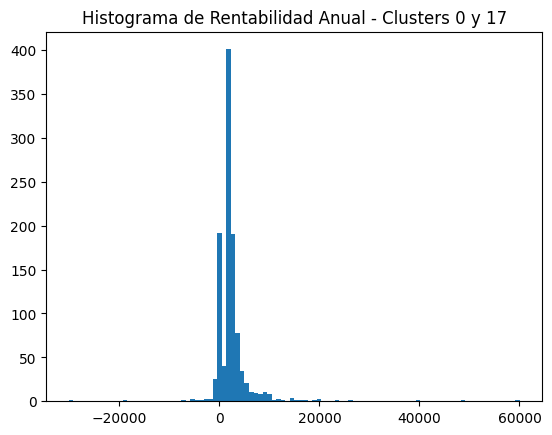

In [ ]:
# histograma de rentabilidad anual
plt.hist(Xtrain_rf_imp_cluster0_17["mrentabilidad"], bins=100)
plt.title("Histograma de Rentabilidad Anual - Clusters 0 y 17")
plt.show()


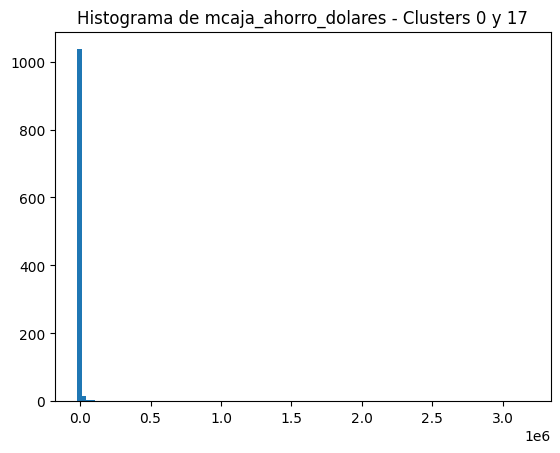

In [ ]:
# histograma de monto caja ahorro
plt.hist(Xtrain_rf_imp_cluster0_17["mcaja_ahorro_dolares"], bins=100)
plt.title("Histograma de mcaja_ahorro_dolares - Clusters 0 y 17")
plt.show()


In [ ]:
# cuantos tienen montos caja ahorro dolares > 0
# separadores de miles para todo y round a 0

Xtrain_rf_imp["mcaja_ahorro_dolares"].groupby(Xtrain_rf_imp["cluster_25"]).describe().round(0).style.format("{:,.0f}")

In [ ]:
# Crear dummy (1 si tiene caja ahorro dólares > 0, 0 en caso contrario)
Xtrain_rf_imp = Xtrain_rf_imp.assign(
    mcaja_ahorro_dolares_dummy = (Xtrain_rf_imp["mcaja_ahorro_dolares"] > 0).astype(int)
)

# Resumen de conteos por cluster
tabla = (
    Xtrain_rf_imp
    .groupby("cluster_25")["mcaja_ahorro_dolares_dummy"]
    .value_counts()
    .unstack(fill_value=0)  # separa en columnas 0 y 1
)

# Formato: separadores de miles y sin decimales
tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")

tabla_fmt


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\765225404.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tabla_fmt = tabla.applymap(lambda x: f"{x:,.0f}")


mcaja_ahorro_dolares_dummy    0    1
cluster_25                          
0                           370  133
1                           253  310
2                           291  226
3                           279   68
4                           297  238
5                           348  589
6                           189  151
7                            85  234
8                           245  130
9                           187  651
10                          214   53
11                          216  178
12                          183  117
13                           84  183
14                          133  183
15                          154  297
16                          212  375
17                          460  105
18                          178  360
19                          154  402
20                          277  185
21                          212  420
22                          220  440
23                          263  217
24                          202  134

In [ ]:
compare_cluster_stats(Xtrain_rf, clusters, 'mpayroll', 24)

Cluster 24  Rest of Clusters
count       336.000000      1.174900e+04
mean       1609.198810      6.709650e+04
std       11420.571989      2.199105e+05
min           0.000000      0.000000e+00
25%           0.000000      0.000000e+00
50%           0.000000      0.000000e+00
75%           0.000000      9.945486e+04
max      124338.000000      1.605681e+07
unique       11.000000      5.349000e+03
missing       0.000000      0.000000e+00

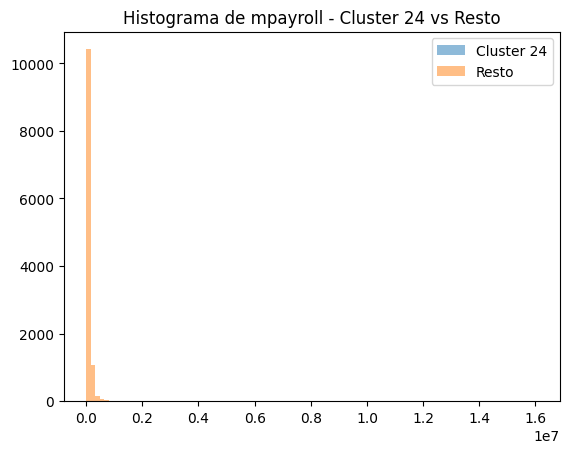

In [ ]:
# histograma comparando mpayroll de cluster 24 vs resto
plt.hist(Xtrain_rf_imp_cluster3["mpayroll"], bins=100, alpha=0.5, label='Cluster 24')
plt.hist(Xtrain_rf_imp[ Xtrain_rf_imp["cluster_25"] != 24]["mpayroll"], bins=100, alpha=0.5, label='Resto')
plt.title("Histograma de mpayroll - Cluster 24 vs Resto")
plt.legend()
plt.show()

In [128]:
Xtrain_rf_imp = Xtrain_rf_imp.copy()
Xtrain_rf_imp["cluster"] = clusters


In [133]:
Xtrain_rf_imp = Xtrain_rf_imp.copy()
Xtrain_rf_imp["cluster"] = clusters

for i in important_features_by_cluster[3]:
    if i == "cluster":  # evitar analizar esa columna
        continue
    print(f"' {i} ' - Cluster 3 vs. Rest")
    display(compare_cluster_stats(Xtrain_rf_imp, clusters, i, 3).round(0).style.format("{:,.0f}"))


' slope_ctrx_quarter_window ' - Cluster 3 vs. Rest


' ctrx_quarter ' - Cluster 3 vs. Rest


' ctrx_quarter_lag_1 ' - Cluster 3 vs. Rest


' ratio_mautoservicio_mpasivos_margen ' - Cluster 3 vs. Rest


' slope_mcaja_ahorro_window ' - Cluster 3 vs. Rest


' mcaja_ahorro_lag_1 ' - Cluster 3 vs. Rest


' mtransferencias_emitidas_lag_1 ' - Cluster 3 vs. Rest


' ratio_mautoservicio_mtarjeta_visa_consumo ' - Cluster 3 vs. Rest


' slope_ctarjeta_debito_transacciones_window ' - Cluster 3 vs. Rest


' slope_mautoservicio_window ' - Cluster 3 vs. Rest


' mautoservicio_lag_1 ' - Cluster 3 vs. Rest


' mtransferencias_emitidas ' - Cluster 3 vs. Rest


' mcuentas_saldo ' - Cluster 3 vs. Rest


' mautoservicio ' - Cluster 3 vs. Rest


In [ ]:
# suponiendo que tu DataFrame se llama Xtrain_rf y tiene columna 'cluster'
features = ["ctrx_quarter",    "internet","mrentabilidad_annual","mcomisiones","mactivos_margen","mpasivos_margen",
    "mcaja_ahorro","mcaja_ahorro_dolares","mprestamos_personales","mprestamos_prendarios",
    "mprestamos_hipotecarios","mplazo_fijo_dolares","mplazo_fijo_pesos","minversion1_pesos",
    "minversion1_dolares","cseguro_vida","cseguro_auto","cseguro_vivienda",
    "cseguro_accidentes_personales","ccaja_seguridad","mpayroll","mpayroll2",
    "mcuenta_debitos_automaticos","mpagodeservicios","mpagomiscuentas",
    "mcomisiones_mantenimiento","mcomisiones_otras","mforex_buy","TC_Total_msaldototal","Master_Finiciomora","Visa_Finiciomora"
]

summary = []


for cl, subdf in Xtrain_rf_imp.groupby("cluster_25"):
    if cl not in [0,17,3,6,23,24,10]:
        continue
    
    desc = subdf[features].describe(percentiles=[0.25, 0.5, 0.75]).T.round(0)
    # Incluyo también la media
    desc = desc[["min", "25%", "50%", "mean", "75%", "max"]]
    desc.reset_index(inplace=True)
    desc.rename(columns={
        "index": "Feature",
        "50%": "Median",
        "mean": "Mean"
    }, inplace=True)
    desc.insert(0, "Cluster", cl)
    
    # aplicar separador de miles
    desc[["min", "25%", "Median", "Mean", "75%", "max"]] = desc[["min", "25%", "Median", "Mean", "75%", "max"]].applymap(
        lambda x: f"{int(x):,}".replace(",", "."))
    summary.append(desc)

    result = pd.concat(summary)


# exportar a Excel
result.to_excel("clusters_summary.xlsx", index=False)


C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\1478889992.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc[["min", "25%", "Median", "Mean", "75%", "max"]] = desc[["min", "25%", "Median", "Mean", "75%", "max"]].applymap(
C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\1478889992.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc[["min", "25%", "Median", "Mean", "75%", "max"]] = desc[["min", "25%", "Median", "Mean", "75%", "max"]].applymap(
C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\1478889992.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc[["min", "25%", "Median", "Mean", "75%", "max"]] = desc[["min", "25%", "Median", "Mean", "75%", "max"]].applymap(
C:\Users\Nico\AppData\Local\Temp\ipykernel_15632\1478889992.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc[["min", "25%", "Median", "Mean", "75%

In [216]:
# esta Master_Finiciomora y Visa_Finiciomora son variables binarias?
Xtrain_rf_v2["Master_Finiciomora"].value_counts()

KeyError: 'Master_Finiciomora'

In [258]:
import pandas as pd

# si Xtrain_rf_imp ya tiene un índice que representa al cliente
Xtrain_rf_imp = pd.DataFrame(Xtrain_rf_imp)

Xtrain_rf_imp = Xtrain_rf_imp.merge(
    Xtrain_rf_v2[["numero_de_cliente", "master_finiciomora", "visa_finiciomora"]],
    on="numero_de_cliente",
    how="left"
)


In [268]:
# columnas que tienen la palabra payroll
columns_salario = Xtrain_rf_imp.filter(like='payroll').columns.tolist()

In [271]:
features = ["ctrx_quarter",    "internet","mrentabilidad_annual","mcomisiones","mactivos_margen","mpasivos_margen",
    "mcaja_ahorro","mcaja_ahorro_dolares","mprestamos_personales","mprestamos_prendarios",
    "mprestamos_hipotecarios","mplazo_fijo_dolares","mplazo_fijo_pesos","minversion1_pesos",
    "minversion1_dolares","cseguro_vida","cseguro_auto","cseguro_vivienda",
    "cseguro_accidentes_personales","ccaja_seguridad","mpayroll","mpayroll2",
    "mcuenta_debitos_automaticos","mpagodeservicios","mpagomiscuentas",
    "mcomisiones_mantenimiento","mcomisiones_otras","mforex_buy","tc_total_msaldototal","master_finiciomora","visa_finiciomora","mpayroll_delta_1"
]

summary_all_clusters = []

for cl, subdf in Xtrain_rf_imp.groupby("cluster_25"):

    # incluir todos los percentiles necesarios
    desc = subdf[features].describe(
        percentiles=[0.10, 0.20, 0.50, 0.75, 0.80, 0.90]
    ).T.round(0)

    # seleccionar columnas en el orden deseado
    desc = desc[["min", "10%", "20%", "50%", "mean", "75%", "80%", "90%", "max"]]

    desc.reset_index(inplace=True)
    desc.rename(columns={
        "index": "Feature",
        "50%": "Median",
        "mean": "Mean"
    }, inplace=True)
    desc.insert(0, "Cluster", cl)

    # aplicar separador de miles y manejar NaN
    cols_to_format = ["min", "10%", "20%", "Median", "Mean", "75%", "80%", "90%", "max"]
    desc[cols_to_format] = desc[cols_to_format].applymap(
        lambda x: f"{int(x):,}".replace(",", ".") if pd.notnull(x) else ""
    )

    summary_all_clusters.append(desc)

# concatenar todos los clusters
result = pd.concat(summary_all_clusters, ignore_index=True)

# exportar a Excel
result.to_excel("clusters_summary_v45.xlsx", index=False)


C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\1022596003.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc[cols_to_format] = desc[cols_to_format].applymap(
C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\1022596003.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc[cols_to_format] = desc[cols_to_format].applymap(
C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\1022596003.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc[cols_to_format] = desc[cols_to_format].applymap(
C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\1022596003.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc[cols_to_format] = desc[cols_to_format].applymap(
C:\Users\Nico\AppData\Local\Temp\ipykernel_5264\1022596003.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  desc[cols_to_format] = desc[cols_t

In [137]:
column_list =Xtrain_rf_imp.columns.to_list()